### Necessary Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import os
import seaborn as sns
import arviz.labels as azl
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from FlYMazeRL.agents.classical import *
from FlYMazeRL.gym.environment import ymaze_baiting,ymaze_static
from FlYMazeRL.utils import generate_params_from_fits,get_schedule_histories
from FlYMazeRL.utils import generate_random_schedule_with_blocks
from scipy import stats
import gym



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
model_database = pd.read_csv("FlYMazeRL/model_description.csv")
# filter to only acceptreject models
model_database = model_database[model_database['Variant'] == 'acceptreject']
# generate maps
model_name_map = {model_database.iloc[i]['SHORTCODE']:model_database.iloc[i]['Model'] for i in range(len(model_database))}
model_simple_abv_map = {model_database.iloc[i]['SHORTCODE']:model_database.iloc[i]['ModelAbv'] for i in range(len(model_database))}
model_class_name_map = {model_database.iloc[i]['AgentClass']:model_database.iloc[i]['SHORTCODE'] for i in range(len(model_database))}

In [3]:
save_model_color_map = {'RewardLearner_acceptreject':'#d28dbd',
    'CQLearner_acceptreject':'#b23493',
    'DFCQLearner_acceptreject':'#92278f',
    'DFOSCQLearner_acceptreject':'#701f60'
    }

def hex_to_rgb(hex_code):
    hex_code = hex_code.strip("#");lv = len(hex_code);rgb = tuple(int(hex_code[i : i + lv // 3], 16) for i in range(0, lv, lv // 3));return rgb
def rgb_to_dec(rgb):
    return [v / 256 for v in rgb]
def get_continuous_cmap(hex_list, float_list=None):
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list: pass
    else: float_list = list(np.linspace(0, 1, len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(["red", "green", "blue"]): col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]; cdict[col] = col_list
    return mcolors.LinearSegmentedColormap("my_cmp", segmentdata=cdict, N=256)

cmap = get_continuous_cmap(["058d96", "00a450", "52b448", "8ac341"])

log = pd.read_csv('FlYMazeRL/data/log.csv')
models = [eval(x) for x in model_class_name_map.keys()]
save_models = ['RewardLearner_acceptreject','CQLearner_acceptreject', 'DFCQLearner_acceptreject','DFOSCQLearner_acceptreject']

In [10]:
import pandas as pd
df = pd.read_csv('FlYMazeRL/model_description.csv')
# filter only accept-reject policies
df = df[df['Variant']=='acceptreject']
# filter only Value-based RL
df = df[df['Model Category']=='Value-Based RL']
df['Model'] = df['SHORTCODE'].map(model_name_map)
df['Abbreviation'] = df['SHORTCODE'].map(model_simple_abv_map)
# group by model and keep only the count and SHORTCODE
df = df.groupby(['Model']).aggregate({'Abbreviation':['count','first']}).reset_index()
df.columns = ['Model','Number of Parameters','Abbreviation']
# invert string of model to create new column
df['InvModel'] = df['Model'].apply(lambda x: x[::-1])
df = df.sort_values(by=['Number of Parameters','InvModel'],ascending=False, na_position = 'first').reset_index(drop=True).drop(columns=['InvModel'])
df.to_latex('FlYMazeRL/model_description.tex', index=False, escape=False)

C:\Users\labadmin\AppData\Local\Temp/ipykernel_40236/3854010686.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex('FlYMazeRL/model_description.tex', index=False, escape=False)


In [11]:
model_dir = "C:/Rishika/Projects/modelfits/acceptreject/"
model_fits = {}
for i in os.listdir(model_dir):
    if i.endswith(".nc"):
        model_fits[i.split('_')[0]] = az.from_netcdf(os.path.join(model_dir, i))

In [12]:
df = []
for m in model_fits.keys():
    temp = az.summary(model_fits[m])
    temp['model'] = model_name_map[m]
    df.append(temp.rename_axis('parameter').reset_index()[['model', 'parameter', 'mean', 'sd', 'hdi_3%', 'hdi_97%', 'ess_bulk','ess_tail','r_hat']])
df = pd.concat(df).reset_index(drop=True)

In [13]:
df['summary'] = df['mean'].apply(lambda x: str(np.round(x,2)))+' ('+df['hdi_3%'].apply(lambda x: str(np.round(x,2)))+'–'+df['hdi_97%'].apply(lambda x: str(np.round(x,2)))+')'# n_eff: '+df['ess_bulk'].apply(lambda x: str(int(x)))+'; Rhat: '+df['r_hat'].apply(lambda x: str(np.round(x,1)))+')'

In [14]:
df_summary = df.pivot_table(index='model', columns='parameter',values='summary', aggfunc='first')
# replace 'nan' with '-'
df_summary = df_summary.replace(np.nan,'-').reset_index()
df_summary.columns = ['Model',r'$\alpha$',r'$\alpha_h$',r'$\alpha_v$',r'$\gamma$',r'$m$',r'$\kappa$',r'$\tau$',r'$\Theta$',r'$\theta_h$',r'$\theta_v$',r'$c$',r'$\w_b$',r'$\w_h$',r'$\w_v$']
col_order = ['Model',r'$\alpha$',r'$\kappa$',r'$\tau$',r'$\gamma$',r'$\Theta$',r'$m$',r'$c$',r'$\alpha_v$',r'$\alpha_h$',r'$\theta_v$',r'$\theta_h$',r'$\w_v$',r'$\w_h$',r'$\w_b$']
df_summary = df_summary[col_order]
df_summary['InvModel'] = df_summary['Model'].apply(lambda x: x[::-1])
df_summary = df_summary.sort_values(by=['InvModel'],ascending=False, na_position = 'first').reset_index(drop=True).drop(columns=['InvModel'])
pd.set_option('display.max_colwidth', None)
# df_summary.to_latex('FlYMazeRL/model_summary.tex', index=False, escape=False)
# split into two dataframes after 8th column
df_summary_1 = df_summary.iloc[:,:8]
df_summary_2 = pd.concat([df_summary.iloc[:,0],df_summary.iloc[:,8:]], axis=1).replace('-',np.nan).dropna()
df_summary_1.to_latex('FlYMazeRL/model_summary_1.tex', index=False, escape=False)
df_summary_2.to_latex('FlYMazeRL/model_summary_2.tex', index=False, escape=False)
df_summary_1

C:\Users\labadmin\AppData\Local\Temp/ipykernel_40236/2394487833.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_summary_1.to_latex('FlYMazeRL/model_summary_1.tex', index=False, escape=False)
C:\Users\labadmin\AppData\Local\Temp/ipykernel_40236/2394487833.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_summary_2.to_latex('FlYMazeRL/model_summary_2.tex', index=False, escape=False)


,Model,$\alpha$,$\kappa$,$\tau$,$\gamma$,$\Theta$,$m$,$c$
0,Forgetting Long-Term Habit-Value Arbiter Q-Learning,-,-,-,0.4 (0.1–0.7),-,-2.03 (-2.98–-1.2),2.67 (1.74–3.63)
1,Long-Term Habit-Value Arbiter Q-Learning,-,-,-,0.64 (0.27–0.86),-,-3.31 (-4.54–-2.16),2.7 (1.85–3.58)
2,Forgetting Immediate Habit-Value Arbiter Q-Learning,-,-,-,-,-,-2.29 (-3.22–-1.41),3.14 (2.33–4.03)
3,Differential Forgetting Immediate Q-Learning,0.09 (0.06–0.13),0.26 (0.17–0.36),-,-,-,-2.34 (-3.29–-1.4),3.07 (2.36–3.83)
4,Forgetting Immediate Q-Learning,0.13 (0.1–0.17),-,-,-,-,-2.1 (-3.08–-1.21),2.48 (2.02–3.05)
5,Immediate Q-Learning,0.06 (0.05–0.08),-,-,-,-,-2.57 (-3.44–-1.79),2.54 (2.1–3.03)
6,Forgetting RPE-free Q-Learning,0.42 (0.32–0.51),-,-,-,-,-1.23 (-1.7–-0.78),0.66 (0.49–0.85)
7,RPE-free Q-Learning,0.49 (0.12–0.94),-,-,-,-,-1.22 (-1.49–-0.94),0.65 (0.19–1.47)
8,Immediate Habit-Value Arbiter Q Learning,-,-,-,-,-,-2.66 (-3.6–-1.78),3.02 (2.24–3.87)
9,Differential Extinction Long-Term Q Learning,0.16 (0.12–0.2),-,0.16 (0.12–0.2),0.82 (0.73–0.9),-,-5.24 (-6.29–-4.13),1.24 (0.94–1.56)


In [444]:
comparison = az.compare(model_fits, ic = 'loo')
comparison.to_csv("FlYMazeRl/fits/AcceptReject_comparison.csv")

C:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\arviz\stats\stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\arviz\stats\stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:

In [15]:
comparison = pd.read_csv("FlYMazeRl/fits/acceptReject_comparison.csv", index_col=0)

In [16]:
comparison.reset_index(inplace=True)
comparison.rename(columns={'index':'model'}, inplace=True)
comparison['model'] = comparison['model'].apply(lambda x: model_simple_abv_map[x])
comparison = comparison.sort_values(by=['rank'], ascending=False)
comparison

,model,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
21,RF-QL,21,-2368.690466,1.938628,126.603366,0.000000e+00,15.065457,16.503674,True,log
20,I-QL,20,-2323.490567,2.522023,81.403467,2.321757e-12,17.312732,13.369528,False,log
19,DE-I-QL,19,-2321.673018,4.065223,79.585919,2.657236e-12,17.318275,13.175352,False,log
18,SARSA,18,-2291.204610,3.441974,49.117511,3.373830e-12,17.852508,10.202992,False,log
17,ESARSA,17,-2281.033413,3.705872,38.946314,1.763299e-12,18.043449,9.909999,True,log
16,I-OS-QL,16,-2279.112255,2.898264,37.025156,7.878240e-02,18.317035,11.437909,False,log
15,DE-LT-QL,15,-2276.803576,4.356473,34.716476,1.024119e-12,18.081157,9.797576,False,log
14,LT-QL,14,-2275.752475,3.677821,33.665376,8.191067e-13,18.119583,9.773841,False,log
13,F-I-QL,13,-2267.770224,2.687809,25.683124,3.600417e-12,19.627146,6.433097,False,log
12,LT-OS-QL,12,-2267.244188,4.142618,25.157088,1.742923e-01,18.543153,10.078963,True,log


In [23]:
comparison = comparison[comparison['model'].apply(lambda x: "HV" not in x)]
comparison = comparison[comparison['model'].apply(lambda x: x[:1] != 'F')]
comparison = comparison[comparison['model'].apply(lambda x: x == 'RF-QL' or x == 'I-QL' or x == 'LT-QL' or x == 'DF-LT-QL' or x == 'DF-LT-OS-QL')]

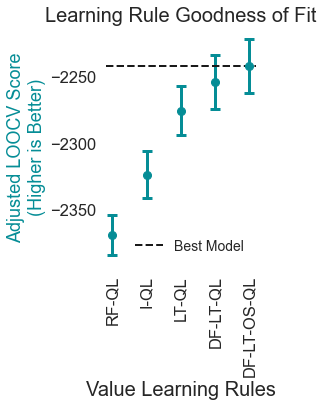

In [26]:
# plt.figure(figsize=(8,6))
# sns.set(font_scale=1.5)
# sns.set_style("whitegrid")
# plt.errorbar(np.arange(len(comparison)), comparison['loo'], yerr=comparison['se'], fmt='o', color='#058d96', capsize=5, linewidth=3, capthick=3,markersize=8)
# plt.errorbar(np.arange(len(comparison))+0.3, comparison['loo'], yerr=comparison['dse'], fmt='o', color='#8ac341', capsize=None, label='Paired difference from Best Model', linewidth=2)
# plt.plot(np.arange(len(comparison)), comparison['loo']+comparison['p_loo'], '^', color='k', label='Unadjusted LOOCV Score')
# plt.axhline(y=np.max(comparison['loo']), color='k', linestyle='--', linewidth=2, label='Best Model Performance')
# plt.xticks(np.arange(len(comparison)), comparison['model'], rotation=90, ha='center')
# plt.ylabel('Adjusted LOOCV Score\n(Higher is Better)', color='#058d96')
# plt.xlabel('Value Learning Rules',fontsize=20)
# plt.title('Learning Rule Goodness of Fit',fontsize=20)
# plt.legend(loc='lower right', fontsize=14, frameon=False)
# plt.grid(False)
# plt.box(False)
# plt.tight_layout()
# plt.savefig("FlYMazeRl/figures/AcceptReject_comparison.svg",transparent=True)
# plt.show()

plt.figure(figsize=(4,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
plt.errorbar(np.arange(len(comparison)), comparison['loo'], yerr=comparison['se'], fmt='o', color='#058d96', capsize=5, linewidth=3, capthick=3,markersize=8)
plt.axhline(y=np.max(comparison['loo']), color='k', linestyle='--', linewidth=2, label='Best Model')
plt.xticks(np.arange(len(comparison)), comparison['model'], rotation=90, ha='center')
plt.ylabel('Adjusted LOOCV Score\n(Higher is Better)', color='#058d96')
plt.xlabel('Value Learning Rules',fontsize=20)
plt.title('Learning Rule Goodness of Fit',fontsize=20)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.grid(False)
plt.box(False)
plt.tight_layout()
plt.savefig("FlYMazeRl/figures/AcceptReject_comparison_alt.svg",transparent=True)
plt.show()

# sns.set(style="ticks")
# labeller = azl.MapLabeller(var_name_map=model_simple_abv_map)
# az.plot_compare(comparison, insample_dev=True, labeller=labeller, plot_kwargs={'marker_insample_dev': '^','color_ic': '#058d96','color_insample_dev': '#8ac341','color_dse': '#000000'})
# fig = plt.gcf()
# fig.set_size_inches(16, 10)
# plt.xlabel('LOOCV Log Score (Higher is Better)')
# plt.ylabel('RL Agents',fontsize=20)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.title('Goodness of Fit Comparison',fontsize=20)
# plt.tight_layout()
# plt.legend({'Naive LOOCV Score':'', 'Best Adjusted LOOCV Score': '', 'Paired Difference from Best Fit': '', 'Adjusted LOOCV Score': ''}, frameon=False, loc='upper left', fontsize=20)
# plt.tight_layout()
# plt.savefig('AcceptReject_comparison.svg',transparent=True)
# plt.show()

In [ ]:
### Predictive power analysis

In [4]:
action_set = np.loadtxt('FlYMazeRL/data/test_action_set.csv', delimiter=',')
reward_set = np.loadtxt('FlYMazeRL/data/test_reward_set.csv', delimiter=',')

RewardLearner_acceptreject
{'alpha': 0.4891292172745334} {'weight': 0.6544401032405445, 'intercept': -1.215790155888309}
(3, 200)


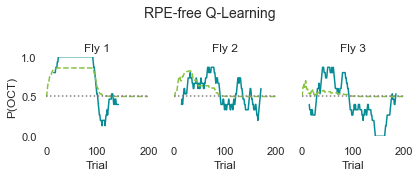

ForgettingRewardLearner_acceptreject
{'alpha': 0.4160887554949002} {'weight': 0.6606801564602386, 'intercept': -1.2320668450884562}
(3, 200)


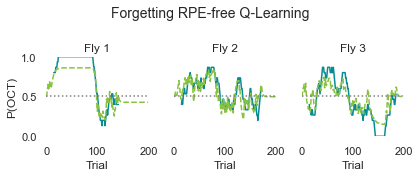

IQLearner_acceptreject
{'alpha': 0.06259754150286732} {'weight': 2.5367670966410296, 'intercept': -2.5706085484373555}
(3, 200)


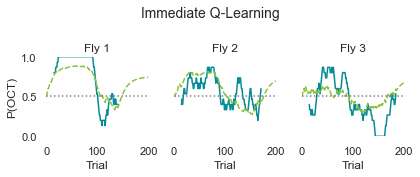

CQLearner_acceptreject
{'alpha': 0.16101832019339862, 'gamma': 0.8216255348723543} {'weight': 1.2253645269528917, 'intercept': -5.286685817535554}
(3, 200)


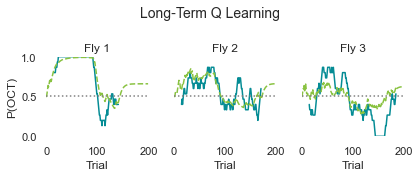

FQLearner_acceptreject
{'alpha': 0.13140174785612635} {'weight': 2.4770534617080875, 'intercept': -2.098884068294337}
(3, 200)


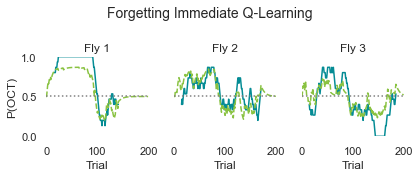

FCQLearner_acceptreject
{'alpha': 0.1732252781514743, 'gamma': 0.5952757094661647} {'weight': 1.7883979816288977, 'intercept': -1.714225052288617}
(3, 200)


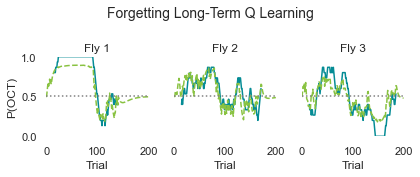

DFQLearner_acceptreject
{'alpha': 0.09275738703866714, 'kappa': 0.26480359040212204} {'weight': 3.0712762394825592, 'intercept': -2.339953237243073}
(3, 200)


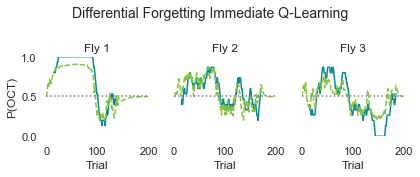

DFCQLearner_acceptreject
{'alpha': 0.25402247360646013, 'gamma': 0.721069143511444, 'kappa': 0.08310416574750688} {'weight': 1.4398977780407485, 'intercept': -2.1802743743826714}
(3, 200)


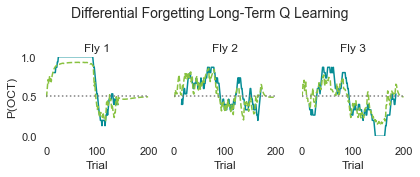

DEQLearner_acceptreject
{'alpha': 0.08831595882063722, 'tau': 0.045202681626562866} {'weight': 2.3933687816520166, 'intercept': -2.9126449311850373}
(3, 200)


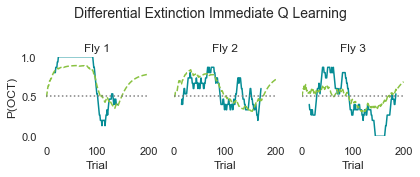

DECQLearner_acceptreject
{'alpha': 0.16009667709007502, 'gamma': 0.8174334356754153, 'tau': 0.16003264179614038} {'weight': 1.2391781913115005, 'intercept': -5.237396558687741}
(3, 200)


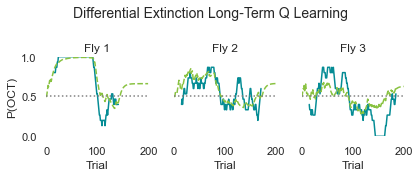

OSQLearner_acceptreject
{'theta': 0.5333850452258417, 'alpha': 0.08696560181579509} {'weight': 3.576729065079302, 'intercept': -4.095047765289145}
(3, 200)


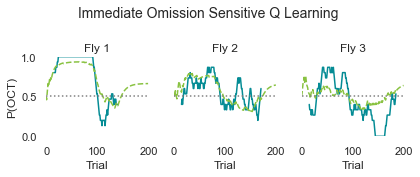

OSCQLearner_acceptreject
{'theta': 0.33538748926751766, 'alpha': 0.1379763979547126, 'gamma': 0.6671893577053138} {'weight': 1.8247627468923233, 'intercept': -5.254756918026445}
(3, 200)


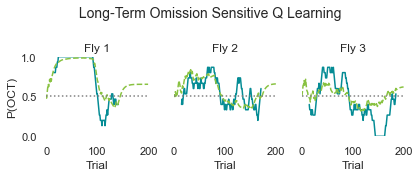

FOSQLearner_acceptreject
{'theta': 0.34250487285193565, 'alpha': 0.14469160773571402} {'weight': 2.5403325457890213, 'intercept': -2.069799189803155}
(3, 200)


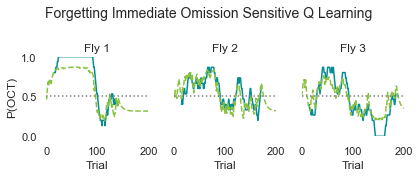

FOSCQLearner_acceptreject
{'theta': 0.24949134779270507, 'alpha': 0.15915627273242922, 'gamma': 0.33066620857330636} {'weight': 2.06716323614718, 'intercept': -1.9457419448454762}
(3, 200)


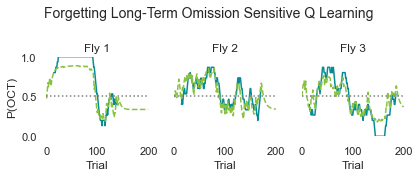

DFOSQLearner_acceptreject
{'theta': 0.5676088019200797, 'alpha': 0.22804632043547954, 'kappa': 0.06432900885182467} {'weight': 2.8743793552333625, 'intercept': -2.652216875713569}
(3, 200)


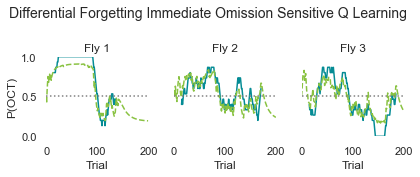

DFOSCQLearner_acceptreject
{'theta': 0.42261442753661393, 'alpha': 0.2591374785654776, 'kappa': 0.05484224236822838, 'gamma': 0.4611706364550362} {'weight': 1.989209942813357, 'intercept': -2.872284382628929}
(3, 200)


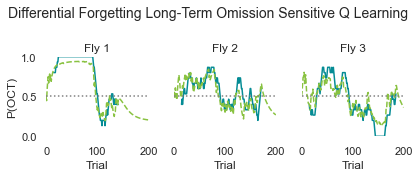

SARSALearner_acceptreject
{'alpha': 0.15706383275811922, 'gamma': 0.8280944228370648} {'weight': 1.1964612672837873, 'intercept': -4.69769358425916}
(3, 200)


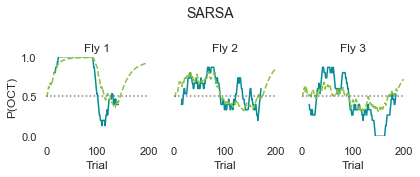

ESARSALearner_acceptreject
{'alpha': 0.14589198146539634, 'gamma': 0.840319277790679} {'weight': 1.376951077637718, 'intercept': -4.9783235642394}
(3, 200)


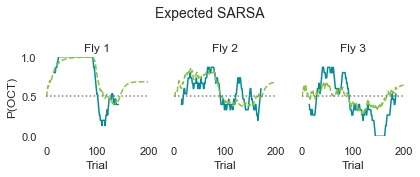

HQLearner_acceptreject
{'weight_r': -0.7932414855584158, 'weight_h': -1.3196359307319951, 'weight_b': -0.11990880338295719, 'alpha_r': 0.37313641307258033, 'alpha_h': 0.12398118510168417} {'weight': 3.018426386951107, 'intercept': -2.6606324867015005, 'theta_r': 0.5482520390557537, 'theta_h': 0.9123873175439275}
(3, 200)


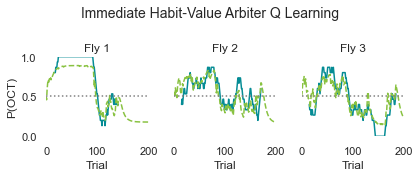

FHQLearner_acceptreject
{'weight_r': 0.030177827048380214, 'weight_h': 0.7275124888867298, 'weight_b': -0.051490080173263335, 'alpha_r': 0.243742822915517, 'alpha_h': 0.22710201797309645} {'weight': 3.143387004965374, 'intercept': -2.28744503544732, 'theta_r': 0.8748412763804139, 'theta_h': 0.7802701666975314}
(3, 200)


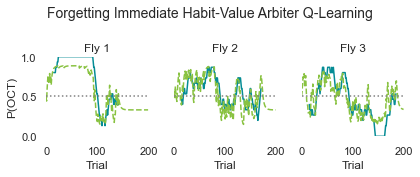

HCQLearner_acceptreject
{'weight_r': 0.07572226129435945, 'weight_h': -1.0509073586576898, 'weight_b': -0.2861782479558648, 'alpha_r': 0.24963265158958342, 'gamma': 0.6385024839561093, 'alpha_h': 0.18024875511434188} {'weight': 2.695772803611484, 'intercept': -3.314098773220208, 'theta_r': 0.7195682111300389, 'theta_h': 0.8672528581004488}
(3, 200)


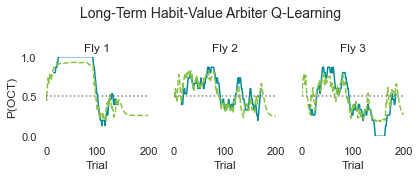

FHCQLearner_acceptreject
{'weight_r': -0.037687466314275005, 'weight_h': 1.1744440343332847, 'weight_b': -0.281892168379173, 'alpha_r': 0.16681357728780433, 'gamma': 0.4038995979313042, 'alpha_h': 0.5830919054523264} {'weight': 2.6665274177628833, 'intercept': -2.0306930121986357, 'theta_r': 0.874037458030441, 'theta_h': 0.6968525119137586}
(3, 200)


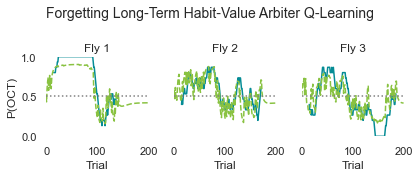

In [5]:
full_nmse = []
saved_preds = []
sns.set(font_scale=1)
for model in models:
    model_name = model.__name__
    print(model_name)

    params, policyparams = generate_params_from_fits(model,1,sample_from_population=False)
    agent = model(ymaze_static(200),params,policyparams)
    print(params,policyparams)
    if model_name != 'HCQLearner_acceptreject' and model_name != 'HQLearner_acceptreject' and model_name != 'FHCQLearner_acceptreject' and model_name != 'FHQLearner_acceptreject':
        p_action = eval(f"agent.vectorizedActionProbabilities({''.join([f'{p}={params[p]},' for p in params]+[f'{p}={policyparams[p]},' for p in policyparams])}actions_set=action_set,rewards_set=reward_set).eval()")
    else:
        p_action = eval(f"agent.vectorizedActionProbabilities({''.join([f'{p}={params[p]},' for p in params]+[f'{p}={policyparams[p]},' for p in policyparams])}actions_set=action_set,rewards_set=reward_set)[0].eval()")
    p_action = p_action.reshape(-1,200)
    print(p_action.shape)

    history_size = 15

    nmses = []
    nliks = []
    for fly in range(p_action.shape[0]):
        obs_action_prob = np.convolve(action_set[fly],np.ones(history_size)/history_size,mode='full')[history_size:200]
        pred_action_prob = p_action[fly,history_size:]
        # remove nans
        nan_mask = ~np.isnan(obs_action_prob)
        obs_action_prob = obs_action_prob[nan_mask]
        pred_action_prob = pred_action_prob[nan_mask]
        mse = np.mean((obs_action_prob-pred_action_prob)**2)
        nmse = mse/np.mean(obs_action_prob**2)
        nmses.append(nmse)
        clipped_action_prob = np.clip(p_action[fly],1e-6,1-1e-6)
        nliks.append(np.exp(np.nanmean(np.log(clipped_action_prob)*action_set[fly]+np.log(1-clipped_action_prob)*(1-action_set[fly]))))
    
    nmse_df = pd.DataFrame({'FlyID':range(p_action.shape[0]),'Model':[model_name]*p_action.shape[0],'Normalized Mean Squared Error':nmses,'Normalized Likelihood':nliks})
    full_nmse.append(nmse_df)

    if model_name in save_models:
        saved_preds.append((model_name,p_action))

    # Plot the best and worst fly
    obs_action_prob = np.convolve(action_set[0],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[0,:]
    plt.figure(figsize=(6,2.5))
    plt.subplot(131)
    plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
    plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
    plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
    # plt.legend(frameon=False,bbox_to_anchor=(1.05,1.05))
    plt.xlim([0,200])
    plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.ylabel('P(OCT)')
    plt.box(False)
    plt.title('Fly 1')

    obs_action_prob = np.convolve(action_set[1],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[1,:]
    plt.subplot(132)
    plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
    plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
    plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
    plt.xlim([0,200])
    plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.yticks([])
    plt.box(False)
    plt.title('Fly 2')

    obs_action_prob = np.convolve(action_set[2],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[2,:]
    plt.subplot(133)
    plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
    plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
    plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
    plt.xlim([0,200])
    plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.yticks([])
    plt.box(False)
    plt.title('Fly 3')

    plt.suptitle(model_name_map[model_class_name_map[model_name]],fontsize=14)
    plt.tight_layout()
    # plt.savefig(f'best_worst_{model_name}.png',dpi=300,transparent=True)
    plt.show()
full_nmse = pd.concat(full_nmse)
full_nmse['Model'] = full_nmse['Model'].apply(lambda x: model_name_map[model_class_name_map[x]])

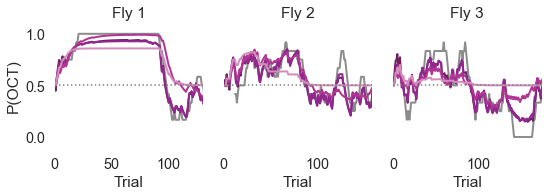

In [198]:
sns.set(font_scale=1.3)


plt.figure(figsize=(8,3))

plt.subplot(131)
obs_action_prob = np.convolve(action_set[0],np.ones(history_size)/history_size,mode='full')[history_size:200]
plt.plot(np.arange(history_size,200),obs_action_prob,color='k',label='Observed',alpha=0.5, linewidth=2)

for model_name,p_action in saved_preds:
    color = save_model_color_map[model_name]
    pred_action_prob = p_action[0,:]#np.convolve(p_action[0,:],np.ones(history_size)/history_size,mode='full')[history_size:200]
    plt.plot(pred_action_prob,'-',color=color,label='Predicted', linewidth=2)

plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
plt.xlim([0,obs_action_prob[np.isnan(obs_action_prob)==False].shape[0]])
plt.ylim([-0.1,1.1])
plt.xlabel('Trial')
plt.ylabel('P(OCT)')
plt.box(False)
plt.title('Fly 1')


plt.subplot(132)
obs_action_prob = np.convolve(action_set[1],np.ones(history_size)/history_size,mode='full')[history_size:200]
plt.plot(np.arange(history_size,200),obs_action_prob,color='k',label='Observed',alpha=0.5, linewidth=2)

for model_name,p_action in saved_preds:
    color = save_model_color_map[model_name]
    pred_action_prob = p_action[1,:]#np.convolve(p_action[0,:],np.ones(history_size)/history_size,mode='full')[history_size:200]
    plt.plot(pred_action_prob,'-',color=color,label='Predicted', linewidth=2)

plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
plt.xlim([0,obs_action_prob[np.isnan(obs_action_prob)==False].shape[0]])
plt.ylim([-0.1,1.1])
plt.yticks([])
plt.xlabel('Trial')
plt.box(False)
plt.title('Fly 2')

plt.subplot(133)
obs_action_prob = np.convolve(action_set[2],np.ones(history_size)/history_size,mode='full')[history_size:200]
plt.plot(np.arange(history_size,200),obs_action_prob,color='k',label='Observed',alpha=0.5, linewidth=2)

for model_name,p_action in saved_preds:
    color = save_model_color_map[model_name]
    pred_action_prob = p_action[2,:]#np.convolve(p_action[0,:],np.ones(history_size)/history_size,mode='full')[history_size:200]
    plt.plot(pred_action_prob,'-',color=color,label='Predicted', linewidth=2)

plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
plt.xlim([0,obs_action_prob[np.isnan(obs_action_prob)==False].shape[0]])
plt.ylim([-0.1,1.1])
plt.yticks([])
plt.xlabel('Trial')
plt.box(False)
plt.title('Fly 3')

plt.tight_layout()
plt.savefig('FlYMazeRL/figures/predictive_power_examples.svg',transparent=True)
plt.show()

In [52]:
rnn_data = np.load('rnn_result.npy')

In [53]:
rnn_data.shape

(3, 200, 2)

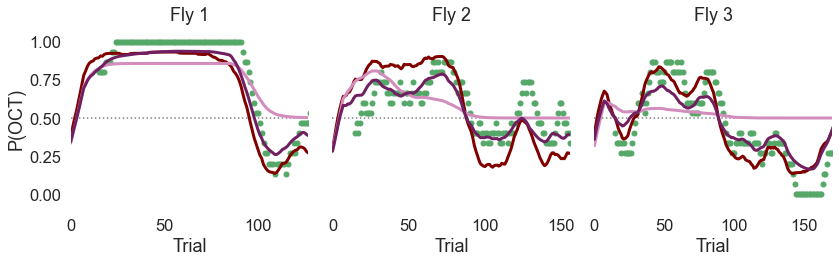

In [66]:
saved_preds_subset = saved_preds[:1]+saved_preds[3:]
history_size = 15
sns.set(font_scale=1.5)

plt.figure(figsize=(12,4))

plt.subplot(131)

plt.plot(np.convolve(rnn_data[0,:,1],np.ones(history_size)/history_size,mode='same'),'-',color='maroon',label='RNN', linewidth=3,zorder=11)

for model_name,p_action in saved_preds_subset:
    color = save_model_color_map[model_name]
    pred_action_prob = np.convolve(p_action[0,:],np.ones(history_size)/history_size,mode='same')
    plt.plot(pred_action_prob,'-',color=color,label='Predicted', linewidth=3,zorder=11)

obs_action_prob = np.convolve(action_set[0],np.ones(history_size)/history_size,mode='full')[history_size:200]
plt.plot(np.arange(history_size,200),obs_action_prob,'.',color='g',label='Observed', markersize=10, zorder=10)

plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
plt.xlim([0,obs_action_prob[np.isnan(obs_action_prob)==False].shape[0]])
plt.ylim([-0.1,1.1])
plt.xlabel('Trial')
plt.ylabel('P(OCT)')
plt.box(False)
plt.title('Fly 1')


plt.subplot(132)

plt.plot(np.convolve(rnn_data[1,:,1],np.ones(history_size)/history_size,mode='same'),'-',color='maroon',label='RNN', linewidth=3,zorder=11)

for model_name,p_action in saved_preds_subset:
    color = save_model_color_map[model_name]
    pred_action_prob = np.convolve(p_action[1,:],np.ones(history_size)/history_size,mode='same')
    plt.plot(pred_action_prob,'-',color=color,label='Predicted', linewidth=3,zorder=11)


obs_action_prob = np.convolve(action_set[1],np.ones(history_size)/history_size,mode='full')[history_size:200]
plt.plot(np.arange(history_size,200),obs_action_prob,'.',color='g',label='Observed', markersize=10, zorder=10)

plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
plt.xlim([0,obs_action_prob[np.isnan(obs_action_prob)==False].shape[0]])
plt.ylim([-0.1,1.1])
plt.yticks([])
plt.xlabel('Trial')
plt.box(False)
plt.title('Fly 2')

plt.subplot(133)

plt.plot(np.convolve(rnn_data[2,:,1],np.ones(history_size)/history_size,mode='same'),'-',color='maroon',label='RNN', linewidth=3,zorder=11)

for model_name,p_action in saved_preds_subset:
    color = save_model_color_map[model_name]
    pred_action_prob = np.convolve(p_action[2,:],np.ones(history_size)/history_size,mode='same')
    plt.plot(pred_action_prob,'-',color=color,label='Predicted', linewidth=3,zorder=11)

obs_action_prob = np.convolve(action_set[2],np.ones(history_size)/history_size,mode='full')[history_size:200]
plt.plot(np.arange(history_size,200),obs_action_prob,'.',color='g',label='Observed', markersize=10, zorder=10)

plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
plt.xlim([0,obs_action_prob[np.isnan(obs_action_prob)==False].shape[0]])
plt.ylim([-0.1,1.1])
plt.yticks([])
plt.xlabel('Trial')
plt.box(False)
plt.title('Fly 3')

plt.tight_layout()
plt.savefig('predictive_power.svg',transparent=True)
plt.show()

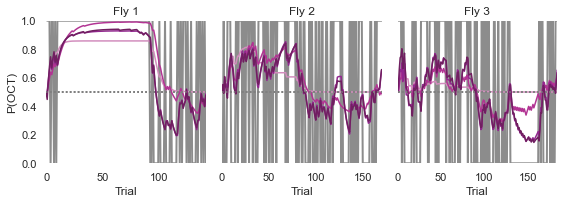

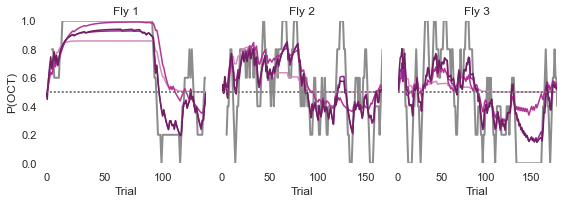

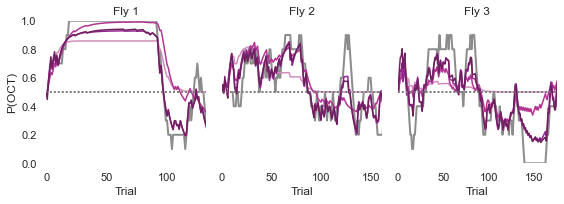

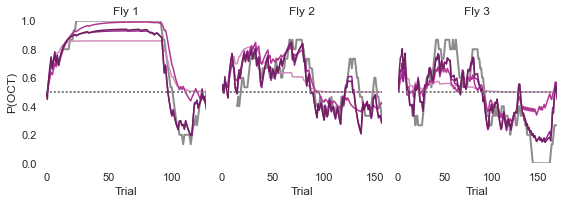

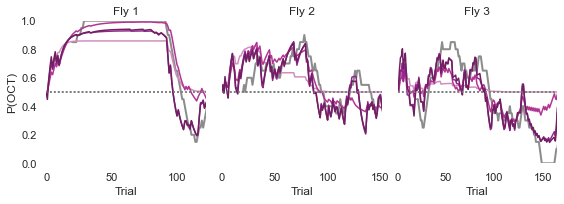

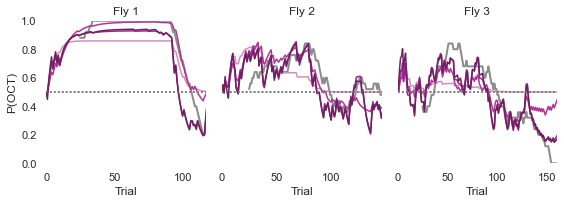

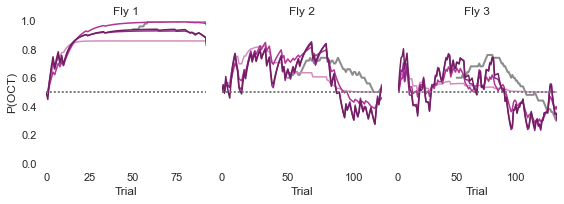

In [238]:
nmsedataset = []
for history_size in [1,5,10,15,20,25,50]:
    full_nmse = []
    sns.set(font_scale=1)
    plt.figure(figsize=(8,3))

    for n, model in enumerate([eval(m) for m in save_models]):
        model_name = model.__name__
        color = save_model_color_map[model_name]
        params, policyparams = generate_params_from_fits(model,1,sample_from_population=False)
        agent = model(ymaze_static(200),params,policyparams)
        if model_name != 'HCQLearner_acceptreject' and model_name != 'HQLearner_acceptreject':
            p_action = eval(f"agent.vectorizedActionProbabilities({''.join([f'{p}={params[p]},' for p in params]+[f'{p}={policyparams[p]},' for p in policyparams])}actions_set=action_set,rewards_set=reward_set).eval()")
        else:
            p_action = eval(f"agent.vectorizedActionProbabilities({''.join([f'{p}={params[p]},' for p in params]+[f'{p}={policyparams[p]},' for p in policyparams])}actions_set=action_set,rewards_set=reward_set)[0].eval()")
        p_action = p_action.reshape(-1,200)
        nmses = []
        nliks = []
        for fly in range(p_action.shape[0]):
            obs_action_prob = np.convolve(action_set[fly],np.ones(history_size)/history_size,mode='full')[history_size:200]
            pred_action_prob = p_action[fly,history_size:]
            # remove nans
            nan_mask = ~np.isnan(obs_action_prob)
            obs_action_prob = obs_action_prob[nan_mask]
            pred_action_prob = pred_action_prob[nan_mask]
            mse = np.mean((obs_action_prob-pred_action_prob)**2)
            nmse = mse/np.mean(obs_action_prob**2)
            nmses.append(nmse)
            clipped_action_prob = np.clip(p_action[fly],1e-6,1-1e-6)
            nliks.append(np.exp(np.nanmean(np.log(clipped_action_prob)*action_set[fly]+np.log(1-clipped_action_prob)*(1-action_set[fly]))))
        
        nmse_df = pd.DataFrame({'FlyID':range(p_action.shape[0]),'Model':[model_name]*p_action.shape[0],'Normalized Mean Squared Error':nmses,'Normalized Likelihood':nliks})
        full_nmse.append(nmse_df)
        # Plot the best and worst fly
        obs_action_prob = np.convolve(action_set[0],np.ones(history_size)/history_size,mode='full')[history_size:200]
        pred_action_prob = p_action[0,:]
        plt.subplot(131)
        if n == 0:
            plt.plot(np.arange(history_size,200),obs_action_prob,color='k',label='Observed',alpha=0.5, linewidth=2)
        plt.plot(pred_action_prob,'-',color=color,label='Predicted')
        plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
        # plt.legend(frameon=False,bbox_to_anchor=(1.05,1.05))
        plt.xlim([0,obs_action_prob[np.isnan(obs_action_prob)==False].shape[0]])
        plt.ylim([0,1])
        plt.xlabel('Trial')
        plt.ylabel('P(OCT)')
        plt.box(False)
        plt.title('Fly 1')
        obs_action_prob = np.convolve(action_set[1],np.ones(history_size)/history_size,mode='full')[history_size:200]
        pred_action_prob = p_action[1,:]
        plt.subplot(132)
        if n == 0:
            plt.plot(np.arange(history_size,200),obs_action_prob,color='k',label='Observed',alpha=0.5, linewidth=2)
        plt.plot(pred_action_prob,'-',color=color,label='Predicted')
        plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
        plt.xlim([0,obs_action_prob[np.isnan(obs_action_prob)==False].shape[0]])
        plt.ylim([0,1])
        plt.xlabel('Trial')
        plt.yticks([])
        plt.box(False)
        plt.title('Fly 2')
        obs_action_prob = np.convolve(action_set[2],np.ones(history_size)/history_size,mode='full')[history_size:200]
        pred_action_prob = p_action[2,:]
        plt.subplot(133)
        if n == 0:
            plt.plot(np.arange(history_size,200),obs_action_prob,color='k',label='Observed',alpha=0.5, linewidth=2)
        plt.plot(pred_action_prob,'-',color=color,label='Predicted')
        plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
        plt.xlim([0,obs_action_prob[np.isnan(obs_action_prob)==False].shape[0]])
        plt.ylim([0,1])
        plt.xlabel('Trial')
        plt.yticks([])
        plt.box(False)
        plt.title('Fly 3')
    plt.tight_layout()
    plt.show()

    full_nmse = pd.concat(full_nmse)
    full_nmse['Model'] = full_nmse['Model'].apply(lambda x: model_name_map[model_class_name_map[x]])
    full_nmse = full_nmse.drop('FlyID',axis=1).groupby(['Model']).agg(['mean','std']).reset_index()
    full_nmse.columns = ['Model','mean_nmse','std_nmse','mean_nliks','std_nliks']
    # full_nmse.set_index('Model',inplace=True)
    # full_nmse = full_nmse.T.reset_index()
    full_nmse['history_size'] = history_size
    nmsedataset.append(full_nmse)


In [239]:
nmsedataset = pd.concat(nmsedataset)

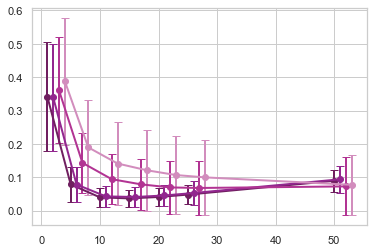

In [295]:
sns.set(style="whitegrid")

for n,i in enumerate(np.unique(nmsedataset['Model'])):
    color = list(save_model_color_map.items())[::-1][n][1]
    subdata = nmsedataset[nmsedataset['Model']==i]
    plt.errorbar(subdata['history_size']+n,subdata['mean_nmse'],yerr=subdata['std_nmse'],label=i,linewidth=2,marker='o',capsize=4,color=color)

In [278]:
nmsedataset

,Model,mean_nmse,std_nmse,mean_nliks,std_nliks,history_size
0,Differential Forgetting Long-Term Omission-Sen...,0.342062,0.162599,0.587508,0.095457,1
1,Differential Forgetting Long-Term Q-Learning,0.339713,0.160357,0.588230,0.093980,1
2,Long-Term Q-Learning,0.360771,0.159166,0.571834,0.081595,1
3,RPE-free Q-Learning,0.387949,0.190322,0.554713,0.085867,1
0,Differential Forgetting Long-Term Omission-Sen...,0.078545,0.053268,0.587508,0.095457,5
1,Differential Forgetting Long-Term Q-Learning,0.078353,0.053663,0.588230,0.093980,5
2,Long-Term Q-Learning,0.143425,0.089703,0.571834,0.081595,5
3,RPE-free Q-Learning,0.189674,0.141541,0.554713,0.085867,5
0,Differential Forgetting Long-Term Omission-Sen...,0.039859,0.028296,0.587508,0.095457,10
1,Differential Forgetting Long-Term Q-Learning,0.042745,0.031545,0.588230,0.093980,10


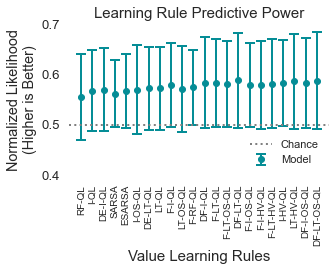

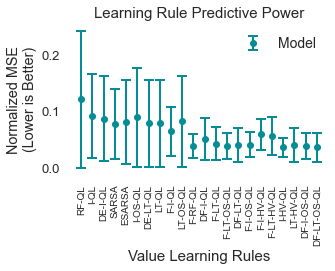

In [25]:
df = full_nmse[['Model','Normalized Likelihood']].groupby('Model').agg(['mean','std']).reset_index()
df.columns = ['model','mean','std']
inv_map = {v: k for k, v in model_name_map.items()}
df.model = df.model.apply(lambda x: model_simple_abv_map[inv_map[x]])
inv_map = {i:j for(i,j) in zip(list(comparison.reset_index(drop=True).reset_index()['model']),list(comparison.reset_index(drop=True).reset_index()['index']))}
df['sortindex'] = df.model.apply(lambda x: inv_map[x])
df.sort_values(by='sortindex',inplace=True)

plt.figure(figsize=(5,4))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

plt.errorbar(np.arange(len(df)),df['mean'],yerr=df['std'],capsize=5,linewidth=2,color='#058d96',label='Model',marker='o',linestyle='None',capthick=2)
plt.axhline(0.5,color='gray',linestyle='dotted',linewidth=2, label='Chance')
plt.xticks(np.arange(len(comparison)), comparison['model'], rotation=90, ha='center',fontsize=10)
plt.ylim([0.4,0.7])
plt.ylabel('Normalized Likelihood\n(Higher is Better)')
plt.xlabel('Value Learning Rules',fontsize=15)
plt.title('Learning Rule Predictive Power',fontsize=15)
plt.legend(loc='lower right', fontsize=11, frameon=False)
plt.grid(False)
plt.box(False)
plt.tight_layout()
plt.savefig("FlYMazeRl/figures/acceptReject_prediction.svg",transparent=True)
plt.show()

df = full_nmse[['Model','Normalized Mean Squared Error']].groupby('Model').agg(['mean','std']).reset_index()
df.columns = ['model','mean','std']
inv_map = {v: k for k, v in model_name_map.items()}
df.model = df.model.apply(lambda x: model_simple_abv_map[inv_map[x]])
inv_map = {i:j for(i,j) in zip(list(comparison.reset_index(drop=True).reset_index()['model']),list(comparison.reset_index(drop=True).reset_index()['index']))}
df['sortindex'] = df.model.apply(lambda x: inv_map[x])
df.sort_values(by='sortindex',inplace=True)

plt.figure(figsize=(5,4))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

plt.errorbar(np.arange(len(df)),df['mean'],yerr=df['std'],capsize=5,linewidth=2,color='#058d96',label='Model',marker='o',linestyle='None',capthick=2)
plt.xticks(np.arange(len(comparison)), comparison['model'], rotation=90, ha='center',fontsize=10)
plt.ylabel('Normalized MSE\n(Lower is Better)')
plt.xlabel('Value Learning Rules',fontsize=15)
plt.title('Learning Rule Predictive Power',fontsize=15)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.grid(False)
plt.box(False)
plt.tight_layout()
plt.savefig("FlYMazeRl/figures/acceptReject_probprediction.svg",transparent=True)
plt.show()

# sns.set(style='ticks')
# sns.set(font_scale=1.5)
# plt.figure(figsize=(13,8))
# sns.pointplot(x='Model',y='Normalized Likelihood',data=full_nmse,palette=cmap(np.linspace(0,1,len(models))),order=full_nmse.groupby('Model').mean()['Normalized Likelihood'].sort_values().index)
# sns.swarmplot(x='Model',y='Normalized Likelihood',data=full_nmse,palette=cmap(np.linspace(1,0,len(models))),size=10,alpha=0.5,order=full_nmse.groupby('Model').mean()['Normalized Likelihood'].sort_values().index)
# plt.box(False)
# plt.xlabel('Normalized Likelihood (Higher is Better)')
# plt.title('Predictive Performance (15 trial history)')
# plt.tight_layout()
# # plt.savefig('predictive_performance_15.png',dpi=300,transparent=True)

In [39]:
np.exp(np.nanmean(np.log(0.5*np.ones((3,200)))*action_set + np.log(1-0.5*np.ones((3,200)))*(1-action_set),axis=1))

array([0.5, 0.5, 0.5])

In [ ]:
sns.set(style='ticks')
sns.set(font_scale=1.5)
plt.figure(figsize=(13,8))
sns.boxplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(0,1,len(models))),order=full_nmse.groupby('Model').mean()['Normalized Mean Squared Error'].sort_values().index)
sns.swarmplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(1,0,len(models))),size=10,alpha=0.5,order=full_nmse.groupby('Model').mean()['Normalized Mean Squared Error'].sort_values().index)
plt.box(False)
plt.xlabel('Normalized Mean Squared Error (Lower is Better)')
plt.title('Predictive Performance (15 trial history)')
plt.tight_layout()
plt.savefig('predictive_performance_15.png',dpi=300,transparent=True)

### Probability Matching Behavior

C:\Users\labadmin\AppData\Local\Temp/ipykernel_34748/3583793268.py:26: RuntimeWarning: divide by zero encountered in true_divide
  reward_probability = np.log(reward_probability/(1-reward_probability))


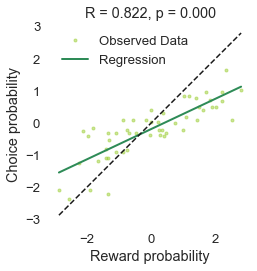

In [47]:
action_set = np.loadtxt('FlYMazeRL/data/action_set.csv', delimiter=',')
reward_set = np.loadtxt('FlYMazeRL/data/reward_set.csv', delimiter=',')

sns.set(font_scale=1.2)
plt.figure()
choice_probability = []
reward_probability = []
for fly in range(len(action_set)):
    for trial in range(80,len(action_set[fly])+41,80):
        action_sample = action_set[fly, trial-80:trial]
        reward_sample = reward_set[fly, trial-80:trial]
        if np.sum(action_sample==0) > 0:
            cumulative_reward_probability_for_action_0 = np.sum(reward_sample[action_sample == 0]) / len(action_sample)
        else:
            cumulative_reward_probability_for_action_0 = 0
        if np.sum(action_sample==1) > 0:
            cumulative_reward_probability_for_action_1 = np.sum(reward_sample[action_sample == 1]) / len(action_sample)
        else:
            cumulative_reward_probability_for_action_1 = 0
        choice_probability.append(np.mean(action_sample))
        reward_probability.append(cumulative_reward_probability_for_action_1/(cumulative_reward_probability_for_action_0+cumulative_reward_probability_for_action_1))

choice_probability = np.array(choice_probability)
reward_probability = np.array(reward_probability)
choice_probability = np.log(choice_probability/(1-choice_probability))
reward_probability = np.log(reward_probability/(1-reward_probability))
acceptable_indices = np.logical_and(np.logical_and(np.isnan(choice_probability)==False,np.isnan(reward_probability)==False),np.logical_and(np.isinf(choice_probability)==False,np.isinf(reward_probability)==False))
choice_probability = choice_probability[acceptable_indices]
reward_probability = reward_probability[acceptable_indices]
plt.plot(reward_probability,choice_probability,'.',alpha=0.5,color='yellowgreen',label='Observed Data')

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(reward_probability,choice_probability)
plt.plot(np.linspace(np.min(reward_probability),np.max(reward_probability),100),slope*np.linspace(np.min(reward_probability),np.max(reward_probability),100)+intercept,'-',color='seagreen',linewidth=2,label='Regression')
plt.xlabel('Reward probability')
plt.ylabel('Choice probability')
plt.title('R = %.3f, p = %.3f' % (r_value, p_value))
plt.plot(np.linspace(np.min(reward_probability),np.max(reward_probability),100),np.linspace(np.min(reward_probability),np.max(reward_probability),100),'k--')

plt.gca().set_aspect('equal', adjustable='box')
plt.box(False)
plt.tight_layout()
plt.legend(frameon=False)
plt.savefig('probability_matching_data.png',dpi=300,transparent=True)
plt.show()

C:\Users\labadmin\AppData\Local\Temp/ipykernel_34748/2893002872.py:26: RuntimeWarning: divide by zero encountered in true_divide
  reward_probability = np.log(reward_probability/(1-reward_probability))


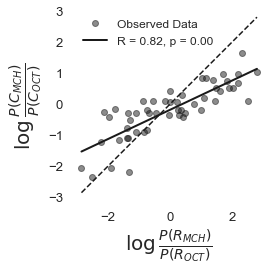

RewardLearner_banditreject


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\labadmin\AppData\Local\Temp/ipykernel_34748/2893002872.py:93: RuntimeWarning: divide by zero encountered in true_divide
  reward_probability = np.log(reward_probability/(1-reward_probability))


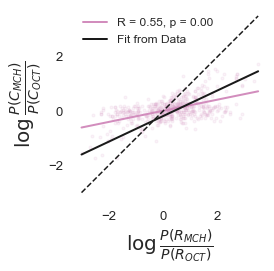

CQLearner_banditreject


  0%|          | 0/10 [00:00<?, ?it/s]

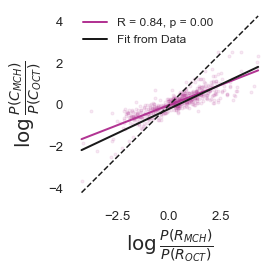

DFCQLearner_banditreject


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\labadmin\AppData\Local\Temp/ipykernel_34748/2893002872.py:93: RuntimeWarning: divide by zero encountered in true_divide
  reward_probability = np.log(reward_probability/(1-reward_probability))


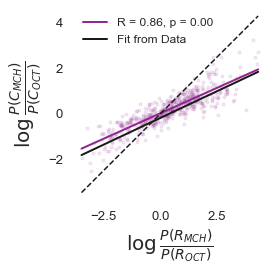

DFOSCQLearner_banditreject


  0%|          | 0/10 [00:00<?, ?it/s]

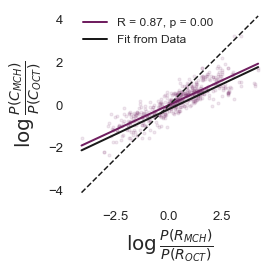

In [53]:
action_set = np.loadtxt('FlYMazeRL/data/action_set.csv', delimiter=',')
reward_set = np.loadtxt('FlYMazeRL/data/reward_set.csv', delimiter=',')

sns.set(font_scale=1.2)
plt.figure(figsize=(4,4))
choice_probability = []
reward_probability = []
for fly in range(len(action_set)):
    for trial in range(80,len(action_set[fly])+41,80):
        action_sample = action_set[fly, trial-80:trial]
        reward_sample = reward_set[fly, trial-80:trial]
        if np.sum(action_sample==0) > 0:
            cumulative_reward_probability_for_action_0 = np.sum(reward_sample[action_sample == 0]) / len(action_sample)
        else:
            cumulative_reward_probability_for_action_0 = 0
        if np.sum(action_sample==1) > 0:
            cumulative_reward_probability_for_action_1 = np.sum(reward_sample[action_sample == 1]) / len(action_sample)
        else:
            cumulative_reward_probability_for_action_1 = 0
        choice_probability.append(np.mean(action_sample))
        reward_probability.append(cumulative_reward_probability_for_action_1/(cumulative_reward_probability_for_action_0+cumulative_reward_probability_for_action_1))

choice_probability = np.array(choice_probability)
reward_probability = np.array(reward_probability)
choice_probability = np.log(choice_probability/(1-choice_probability))
reward_probability = np.log(reward_probability/(1-reward_probability))
acceptable_indices = np.logical_and(np.logical_and(np.isnan(choice_probability)==False,np.isnan(reward_probability)==False),np.logical_and(np.isinf(choice_probability)==False,np.isinf(reward_probability)==False))
choice_probability = choice_probability[acceptable_indices]
reward_probability = reward_probability[acceptable_indices]
plt.plot(reward_probability,choice_probability,'o',alpha=0.5,color='k',label='Observed Data')

from scipy import stats
slope_t, intercept_t, r_value, p_value, std_err = stats.linregress(reward_probability,choice_probability)
plt.plot(np.linspace(np.min(reward_probability),np.max(reward_probability),100),slope_t*np.linspace(np.min(reward_probability),np.max(reward_probability),100)+intercept_t,'-',color='k',linewidth=2,label='R = %.2f, p = %.2f' % (r_value, p_value))

plt.xlabel(r'$\log\frac{P(R_{MCH})}{P(R_{OCT})}$', fontsize=20)
plt.ylabel(r'$\log\frac{P(C_{MCH})}{P(C_{OCT})}$', fontsize=20)
# plt.title('R = %.3f, p = %.3f' % (r_value, p_value))
plt.plot(np.linspace(np.min(reward_probability),np.max(reward_probability),100),np.linspace(np.min(reward_probability),np.max(reward_probability),100),'k--')
plt.gca().set_aspect('equal', adjustable='box')
plt.box(False)
plt.tight_layout()
plt.legend(frameon=False, fontsize=12)
plt.savefig('true_probability_matching_data.svg',transparent=True)
plt.show()

n_samples = 18
repeats = 10
n_blocks = 3
size_block = 80

for model in [eval(x) for x in save_models]:
    model_name = model.__name__
    color = save_model_color_map[model_name]
    print(model_name)
    params, policy_params = generate_params_from_fits(agentClass=model,n_samples=n_samples,sample_from_population=True)

    action_set = []
    reward_set = []
    for r in tqdm(range(repeats)):
        for i in range(n_samples):
            p_vals = log.loc[i,'p1':'p4']
            env = ymaze_baiting(n_trials_per_session=size_block*n_blocks, n_trial_per_blocks = [size_block]*n_blocks, baiting_probabilities=[[p_vals[k],1-p_vals[k]] for k in range(n_blocks)])
            agent = model(env, params[i], policy_params[i])
            agent.next_episode()
            action_set.append(agent.action_history)
            reward_set.append(agent.reward_history)

    action_set = np.array(action_set)
    reward_set = np.array(reward_set)

    choice_probability = []
    reward_probability = []
    for fly in range(n_samples*repeats):
        for trial in range(size_block,len(action_set[fly])+1,size_block):
            action_sample = action_set[fly, trial-size_block:trial]
            reward_sample = reward_set[fly, trial-size_block:trial]
            if np.sum(action_sample==0) > 0:
                cumulative_reward_probability_for_action_0 = np.sum(reward_sample[action_sample == 0]) / len(action_sample)
            else:
                cumulative_reward_probability_for_action_0 = 0
            if np.sum(action_sample==1) > 0:
                cumulative_reward_probability_for_action_1 = np.sum(reward_sample[action_sample == 1]) / len(action_sample)
            else:
                cumulative_reward_probability_for_action_1 = 0

            choice_probability.append(np.mean(action_sample))
            reward_probability.append(cumulative_reward_probability_for_action_1/(cumulative_reward_probability_for_action_0+cumulative_reward_probability_for_action_1))

    choice_probability = np.array(choice_probability)
    reward_probability = np.array(reward_probability)
    choice_probability = np.log(choice_probability/(1-choice_probability))
    reward_probability = np.log(reward_probability/(1-reward_probability))
    acceptable_indices = np.logical_and(np.logical_and(np.isnan(choice_probability)==False,np.isnan(reward_probability)==False),np.logical_and(np.isinf(choice_probability)==False,np.isinf(reward_probability)==False))
    choice_probability = choice_probability[acceptable_indices]
    reward_probability = reward_probability[acceptable_indices]
    
    plt.figure(figsize=(4,4))

    plt.plot(reward_probability,choice_probability,'.',alpha=0.1,color=color)

    slope, intercept, r_value, p_value, std_err = stats.linregress(reward_probability,choice_probability)
    plt.plot(np.linspace(np.min(reward_probability),np.max(reward_probability),100),slope*np.linspace(np.min(reward_probability),np.max(reward_probability),100)+intercept,'-',color=color,linewidth=2,label='R = %.2f, p = %.2f' % (r_value, p_value))
    plt.plot(np.linspace(np.min(reward_probability),np.max(reward_probability),100),slope_t*np.linspace(np.min(reward_probability),np.max(reward_probability),100)+intercept_t,'-',color='k',linewidth=2,label='Fit from Data')

    plt.xlabel(r'$\log\frac{P(R_{MCH})}{P(R_{OCT})}$', fontsize=20)
    plt.ylabel(r'$\log\frac{P(C_{MCH})}{P(C_{OCT})}$', fontsize=20)
    # plt.title('R = %.3f, p = %.3f' % (r_value, p_value))
    plt.plot(np.linspace(np.min(reward_probability),np.max(reward_probability),100),np.linspace(np.min(reward_probability),np.max(reward_probability),100),'k--')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.box(False)
    plt.tight_layout()
    plt.legend(frameon=False, fontsize=12)
    plt.savefig(f'{model_name}_probability_matching_data.svg',transparent=True)
    plt.show()

In [13]:
n_samples = 18
n_blocks = 3
size_block = 80

for model in models:
    model_name = model.__name__
    print(model_name)
    params, policy_params = generate_params_from_fits(agentClass=model,n_samples=n_samples,sample_from_population=True)

    action_set = []
    reward_set = []
    for i in tqdm(range(n_samples)):
        p_vals = log.loc[i,'p1':'p4']
        env = ymaze_baiting(n_trials_per_session=size_block*n_blocks, n_trial_per_blocks = [size_block]*n_blocks, baiting_probabilities=[[p_vals[k],1-p_vals[k]] for k in range(n_blocks)])
        agent = model(env, params[i], policy_params[i])
        agent.next_episode()
        action_set.append(agent.action_history)
        reward_set.append(agent.reward_history)

    action_set = np.array(action_set)
    reward_set = np.array(reward_set)

    plt.figure()
    choice_probability = []
    reward_probability = []
    for fly in range(n_samples):
        for trial in range(size_block,len(action_set[fly])+1,size_block):
            action_sample = action_set[fly, trial-size_block:trial]
            reward_sample = reward_set[fly, trial-size_block:trial]
            if np.sum(action_sample==0) > 0:
                cumulative_reward_probability_for_action_0 = np.sum(reward_sample[action_sample == 0]) / len(action_sample)
            else:
                cumulative_reward_probability_for_action_0 = 0
            if np.sum(action_sample==1) > 0:
                cumulative_reward_probability_for_action_1 = np.sum(reward_sample[action_sample == 1]) / len(action_sample)
            else:
                cumulative_reward_probability_for_action_1 = 0

            choice_probability.append(np.mean(action_sample))
            reward_probability.append(cumulative_reward_probability_for_action_1/(cumulative_reward_probability_for_action_0+cumulative_reward_probability_for_action_1))

    choice_probability = np.array(choice_probability)
    reward_probability = np.array(reward_probability)
    acceptable_indices = np.logical_and(np.isnan(choice_probability)==False,np.isnan(reward_probability)==False)
    plt.plot(reward_probability[acceptable_indices],choice_probability[acceptable_indices],'.',alpha=0.5,color='yellowgreen')

    slope, intercept, r_value, p_value, std_err = stats.linregress(reward_probability[acceptable_indices],choice_probability[acceptable_indices])
    plt.plot(np.arange(0,1.1,0.1),slope*np.arange(0,1.1,0.1)+intercept,'-',color='seagreen',linewidth=2)
    plt.xlabel('Reward probability')
    plt.ylabel('Choice probability')
    plt.title(f'{model_name_map[model_class_name_map[model_name]]}\nR = {r_value:.3f}, p = {p_value:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.ylim([0,1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.box(False)
    plt.tight_layout()
    plt.savefig(f'probability_matching_{model_name}.png',dpi=300,transparent=True)
    plt.show()

HCQLearner_banditreject


  0%|          | 0/18 [00:00<?, ?it/s]

NameError: name 'log' is not defined

In [ ]:
n_samples = 18
n_blocks = 3
size_block = 80
repeats = 10

for model in models:
    model_name = model.__name__
    params, policy_params = generate_params_from_fits(agentClass=model,n_samples=n_samples,sample_from_population=True)

    action_set = []
    reward_set = []
    for r in tqdm(range(repeats)):
        for i in range(n_samples):
            p_vals = log.loc[i,'p1':'p4']
            env = ymaze_baiting(n_trials_per_session=size_block*n_blocks, n_trial_per_blocks = [size_block]*n_blocks, baiting_probabilities=[[p_vals[k],1-p_vals[k]] for k in range(n_blocks)])
            agent = model(env, params[i], policy_params[i])
            agent.next_episode()
            action_set.append(agent.action_history)
            reward_set.append(agent.reward_history)
    action_set = np.array(action_set)
    reward_set = np.array(reward_set)

    exploration_data = pd.DataFrame(columns=['Fly Number','History Length', 'Greedy Exploration Rate'])

    for fly in tqdm(range(len(action_set))):
        for history_window in [2,5,10,15,20,50,100,200]:
            greedy_explore_count = 0
            for trial in range(1,len(action_set[fly])):
                action_sample = action_set[fly, np.max([0, trial-history_window]):trial]
                reward_sample = reward_set[fly, np.max([0, trial-history_window]):trial]
                actual_action = action_set[fly, trial]

                if np.sum(action_sample==0) > 0:
                    cumulative_reward_probability_for_action_0 = np.sum(reward_sample[action_sample == 0]) / len(action_sample) #/ np.sum(action_sample == 0)
                else:
                    cumulative_reward_probability_for_action_0 = 0
                if np.sum(action_sample==1) > 0:
                    cumulative_reward_probability_for_action_1 = np.sum(reward_sample[action_sample == 1]) / len(action_sample) #/ np.sum(action_sample == 1)
                else:
                    cumulative_reward_probability_for_action_1 = 0
                predicted_action = np.argmax([cumulative_reward_probability_for_action_0, cumulative_reward_probability_for_action_1])
                if predicted_action != actual_action:
                    greedy_explore_count += 1
            greedy_explore_rate = greedy_explore_count / len(action_set[fly])
            exploration_data.loc[exploration_data.shape[0]] = [fly+1, history_window, greedy_explore_rate]

    plt.figure()
    sns.boxplot(x='History Length', y='Greedy Exploration Rate', data=exploration_data, palette=cmap(np.linspace(0,1,8)))
    sns.stripplot(x='History Length', y='Greedy Exploration Rate', data=exploration_data, jitter=True, palette=cmap(np.linspace(1,0,8)))
    plt.box(False)
    plt.xlabel('Length of history considered')
    plt.ylabel('P(greedy option was not chosen)')
    plt.title(f'{model_name_map[model_class_name_map[model_name]]}')
    plt.tight_layout()
    plt.savefig(f'exploration_{model_name}.png',dpi=300,transparent=True)
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

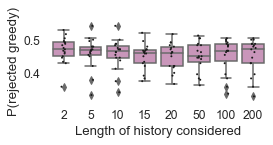

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

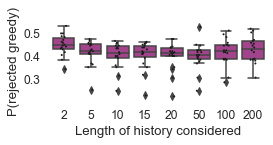

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

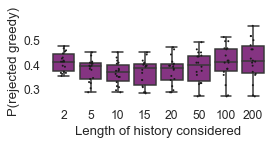

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

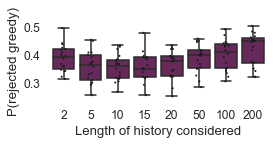

In [18]:
n_samples = 18
n_blocks = 3
size_block = 80
repeats = 1

for model in [eval(m) for m in save_models]:
    color = save_model_color_map[model.__name__]
    model_name = model.__name__
    params, policy_params = generate_params_from_fits(agentClass=model,n_samples=n_samples,sample_from_population=True)

    action_set = []
    reward_set = []
    for r in tqdm(range(repeats)):
        for i in range(n_samples):
            p_vals = log.loc[i,'p1':'p4']
            env = ymaze_baiting(n_trials_per_session=size_block*n_blocks, n_trial_per_blocks = [size_block]*n_blocks, baiting_probabilities=[[p_vals[k],1-p_vals[k]] for k in range(n_blocks)])
            agent = model(env, params[i], policy_params[i])
            agent.next_episode()
            action_set.append(agent.action_history)
            reward_set.append(agent.reward_history)
    action_set = np.array(action_set)
    reward_set = np.array(reward_set)

    exploration_data = pd.DataFrame(columns=['Fly Number','History Length', 'Greedy Exploration Rate'])

    for fly in tqdm(range(len(action_set))):
        for history_window in [2,5,10,15,20,50,100,200]:
            greedy_explore_count = 0
            for trial in range(1,len(action_set[fly])):
                action_sample = action_set[fly, np.max([0, trial-history_window]):trial]
                reward_sample = reward_set[fly, np.max([0, trial-history_window]):trial]
                actual_action = action_set[fly, trial]

                if np.sum(action_sample==0) > 0:
                    cumulative_reward_probability_for_action_0 = np.sum(reward_sample[action_sample == 0]) / len(action_sample) #/ np.sum(action_sample == 0)
                else:
                    cumulative_reward_probability_for_action_0 = 0
                if np.sum(action_sample==1) > 0:
                    cumulative_reward_probability_for_action_1 = np.sum(reward_sample[action_sample == 1]) / len(action_sample) #/ np.sum(action_sample == 1)
                else:
                    cumulative_reward_probability_for_action_1 = 0
                predicted_action = np.argmax([cumulative_reward_probability_for_action_0, cumulative_reward_probability_for_action_1])
                if predicted_action != actual_action:
                    greedy_explore_count += 1
            greedy_explore_rate = greedy_explore_count / len(action_set[fly])
            exploration_data.loc[exploration_data.shape[0]] = [fly+1, history_window, greedy_explore_rate]

    sns.set(style="whitegrid")
    sns.set(font_scale=1.1)
    plt.figure(figsize=(4,2))
    sns.boxplot(x='History Length', y='Greedy Exploration Rate', data=exploration_data, color=color)
    sns.stripplot(x='History Length', y='Greedy Exploration Rate', data=exploration_data, jitter=True, color='k', alpha=1, size=2)
    plt.xticks([0,1,2,3,4,5,6,7], [2,5,10,15,20,50,100,200])
    plt.box(False)
    plt.xlabel('Length of history considered')
    plt.ylabel('P(rejected greedy)')
    plt.tight_layout()
    plt.savefig(f'exploration_{model_name}.svg',transparent=True)
    plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]

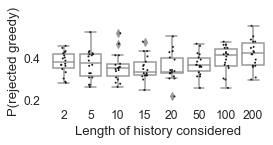

In [19]:
action_set = np.loadtxt('FlYMazeRL/data/action_set.csv', delimiter=',')
reward_set = np.loadtxt('FlYMazeRL/data/reward_set.csv', delimiter=',')

exploration_data = pd.DataFrame(columns=['Fly Number','History Length', 'Greedy Exploration Rate'])

for fly in tqdm(range(len(action_set))):
    for history_window in [2,5,10,15,20,50,100,200]:
        greedy_explore_count = 0
        for trial in range(1,len(action_set[fly])):
            action_sample = action_set[fly, np.max([0, trial-history_window]):trial]
            reward_sample = reward_set[fly, np.max([0, trial-history_window]):trial]
            actual_action = action_set[fly, trial]

            if np.sum(action_sample==0) > 0:
                cumulative_reward_probability_for_action_0 = np.sum(reward_sample[action_sample == 0]) / len(action_sample) #/ np.sum(action_sample == 0)
            else:
                cumulative_reward_probability_for_action_0 = 0
            if np.sum(action_sample==1) > 0:
                cumulative_reward_probability_for_action_1 = np.sum(reward_sample[action_sample == 1]) / len(action_sample) #/ np.sum(action_sample == 1)
            else:
                cumulative_reward_probability_for_action_1 = 0
            predicted_action = np.argmax([cumulative_reward_probability_for_action_0, cumulative_reward_probability_for_action_1])
            if predicted_action != actual_action:
                greedy_explore_count += 1
        greedy_explore_rate = greedy_explore_count / len(action_set[fly])
        exploration_data.loc[exploration_data.shape[0]] = [fly+1, history_window, greedy_explore_rate]

sns.set(style="whitegrid")
sns.set(font_scale=1.1)
plt.figure(figsize=(4,2))
sns.boxplot(x='History Length', y='Greedy Exploration Rate', data=exploration_data, color='white')
sns.stripplot(x='History Length', y='Greedy Exploration Rate', data=exploration_data, jitter=True, color='k', alpha=1, size=2)
plt.xticks([0,1,2,3,4,5,6,7], [2,5,10,15,20,50,100,200])
plt.box(False)
plt.xlabel('Length of history considered')
plt.ylabel('P(rejected greedy)')
plt.tight_layout()
plt.savefig('exploration_data.svg', transparent=True)
plt.show()

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
epsilon_df = []
for model in model_fits:
    temp = pd.DataFrame(columns=['Model','Baseline Acceptance Rate'])
    temp['Baseline Acceptance Rate'] = sigmoid(model_fits[model].posterior.intercept.values.flatten())
    temp['Model'] = model_name_map[model]
    epsilon_df.append(temp)
epsilon_df = pd.concat(epsilon_df)

In [21]:
sns.set(style="ticks")
sns.set(font_scale=1.5)
plt.figure(figsize=(9,5))
sns.boxplot(y='Model', x='Baseline Acceptance Rate', data=epsilon_df, palette=cmap(np.linspace(0,1,len(model_fits))),showfliers=False,order=full_nmse.groupby('Model').median()['Normalized Mean Squared Error'].sort_values().index)
plt.box(False)
plt.tight_layout()
plt.savefig('epsilon_boxplot.png', dpi=300, transparent=True)

NameError: name 'full_nmse' is not defined

<Figure size 648x360 with 0 Axes>

In [43]:
beta_df = []
for model in model_fits:
    temp = pd.DataFrame(columns=['Model','Value Weights'])
    temp['Value Weights'] = model_fits[model].posterior.weight.values.flatten()
    temp['Model'] = model_name_map[model]
    beta_df.append(temp)
beta_df = pd.concat(beta_df)

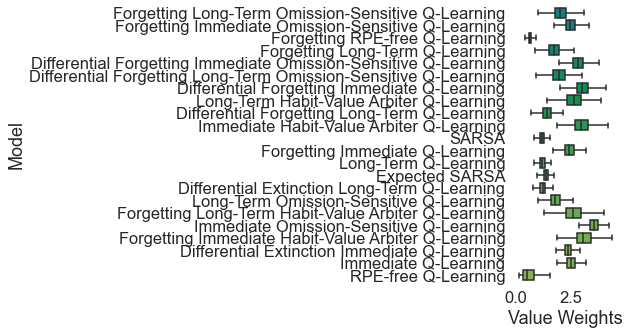

In [44]:
sns.set(style="ticks")
sns.set(font_scale=1.5)
plt.figure(figsize=(9,5))
sns.boxplot(y='Model', x='Value Weights', data=beta_df, palette=cmap(np.linspace(0,1,len(model_fits))),showfliers=False,order=full_nmse.groupby('Model').median()['Normalized Mean Squared Error'].sort_values().index)
plt.box(False)
plt.tight_layout()
plt.savefig('beta_boxplot.png', dpi=300, transparent=True)

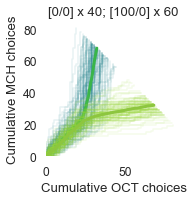

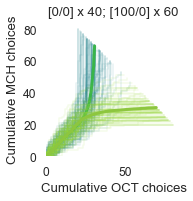

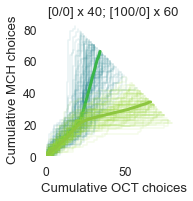

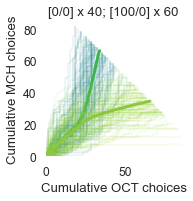

In [22]:
from FlYMazeRL.utils import generate_random_schedule_with_blocks

n_agents = 100
for model in [eval(m) for m in save_models]:
    sns.set(style="ticks")
    sns.set(font_scale=1.1)
    plt.figure(figsize=(3,3))

    env = ymaze_static(100,schedule=generate_random_schedule_with_blocks(100,[0,0],[0,1],equal=False,block_sizes=[40,60]))
    params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
    histories = get_schedule_histories(env, model, n_agents, params, policyparams)
    histories = np.array(histories)

    for j in range(n_agents):
        plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.45),alpha=0.1)
    plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color='#39b54a')

    env = ymaze_static(100,schedule=generate_random_schedule_with_blocks(100,[0,1],[0,0],equal=False,block_sizes=[40,60]))
    params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
    histories = get_schedule_histories(env, model, n_agents, params, policyparams)
    histories = np.array(histories)

    for j in range(n_agents):
        plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.85),alpha=0.1)
    plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color='#8dc63f')

    plt.xlabel('Cumulative OCT choices')
    plt.ylabel('Cumulative MCH choices')
    plt.box(False)
    plt.gca().set_aspect('equal')
    plt.title('[0/0] x 40; [100/0] x 60')
    plt.xlim([0,85])
    plt.ylim([0,85])
    plt.tight_layout()
    plt.savefig(f'100_0_{model.__name__}.svg', transparent=True)
    plt.show()

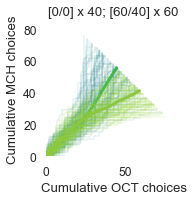

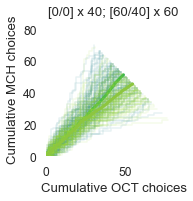

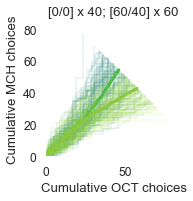

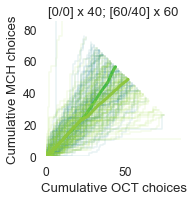

In [23]:
from FlYMazeRL.utils import generate_random_schedule_with_blocks

n_agents = 100
for model in [eval(m) for m in save_models]:
    sns.set(style="ticks")
    sns.set(font_scale=1.1)
    plt.figure(figsize=(3,3))

    env = ymaze_static(100,schedule=generate_random_schedule_with_blocks(100,[0,0.4],[0,0.6],equal=False,block_sizes=[40,60]))
    params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
    histories = get_schedule_histories(env, model, n_agents, params, policyparams)
    histories = np.array(histories)

    for j in range(n_agents):
        plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.45),alpha=0.1)
    plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color='#39b54a')

    env = ymaze_static(100,schedule=generate_random_schedule_with_blocks(100,[0,0.6],[0,0.4],equal=False,block_sizes=[40,60]))
    params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
    histories = get_schedule_histories(env, model, n_agents, params, policyparams)
    histories = np.array(histories)

    for j in range(n_agents):
        plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.85),alpha=0.1)
    plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color='#8dc63f')

    plt.xlabel('Cumulative OCT choices')
    plt.ylabel('Cumulative MCH choices')
    plt.box(False)
    plt.gca().set_aspect('equal')
    plt.title('[0/0] x 40; [60/40] x 60')
    plt.xlim([0,85])
    plt.ylim([0,85])
    plt.tight_layout()
    plt.savefig(f'60_40_{model.__name__}.svg', transparent=True)
    plt.show()

In [ ]:
from FlYMazeRL.utils import generate_random_schedule_with_blocks

n_agents = 100
model = CQLearner_acceptreject
sns.set(style="ticks")
plt.figure(figsize=(5,5))

env = ymaze_static(200,schedule=generate_random_schedule_with_blocks(200,[0,0.8],[0,0.2],equal=False,block_sizes=[80,120]))
params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
histories = get_schedule_histories(env, model, n_agents, params, policyparams)
histories = np.array(histories)

for j in range(n_agents):
    plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.5),alpha=0.1)
plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=plt.cm.viridis(0.3))

env = ymaze_static(200,schedule=generate_random_schedule_with_blocks(200,[0,0.2],[0,0.8],equal=False,block_sizes=[80,120]))
params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
histories = get_schedule_histories(env, model, n_agents, params, policyparams)
histories = np.array(histories)

for j in range(n_agents):
    plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.9),alpha=0.1)
plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=plt.cm.viridis(0.95))

plt.xlabel('Cumulative number of OCT choices')
plt.ylabel('Cumulative number of MCH choices')
plt.box(False)
plt.gca().set_aspect('equal')
plt.title('80%:20% reward on odors')
plt.tight_layout()
plt.savefig('80_20_reward_on_odors.png', dpi=300, transparent=True)


In [ ]:
from FlYMazeRL.utils import generate_random_schedule_with_blocks

n_agents = 100
model = CQLearner_acceptreject
sns.set(style="ticks")
plt.figure(figsize=(5,5))

env = ymaze_static(200,schedule=generate_random_schedule_with_blocks(200,[0,0.6],[0,0.4],equal=False,block_sizes=[80,120]))
params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
histories = get_schedule_histories(env, model, n_agents, params, policyparams)
histories = np.array(histories)

for j in range(n_agents):
    plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.5),alpha=0.1)
plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=plt.cm.viridis(0.3))

env = ymaze_static(200,schedule=generate_random_schedule_with_blocks(200,[0,0.4],[0,0.6],equal=False,block_sizes=[80,120]))
params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
histories = get_schedule_histories(env, model, n_agents, params, policyparams)
histories = np.array(histories)

for j in range(n_agents):
    plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.9),alpha=0.1)
plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=plt.cm.viridis(0.95))

plt.xlabel('Cumulative number of OCT choices')
plt.ylabel('Cumulative number of MCH choices')
plt.box(False)
plt.gca().set_aspect('equal')
plt.title('60%:40% reward on odors')
plt.tight_layout()
plt.savefig('60_40_reward_on_odors.png', dpi=300, transparent=True)

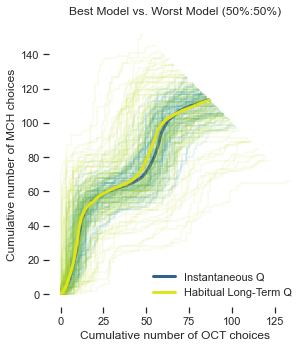

In [102]:
n_agents = 100
sns.set(style="ticks")
plt.figure(figsize=(5,5))

model = IQLearner_acceptreject
env = ymaze_static(200,schedule=generate_random_schedule_with_blocks(200,[0,1,0,1],[1,0,1,0],equal=False,block_sizes=[50,50,50,50]))
params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
histories = get_schedule_histories(env, model, n_agents, params, policyparams)
histories = np.array(histories)

for j in range(n_agents):
    plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.5),alpha=0.1)
plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=plt.cm.viridis(0.3),label='Instantaneous Q')

model = HCQLearner_acceptreject
env = ymaze_static(200,schedule=generate_random_schedule_with_blocks(200,[0,1,0,1],[1,0,1,0],equal=False,block_sizes=[50,50,50,50]))
params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
histories = get_schedule_histories(env, model, n_agents, params, policyparams)
histories = np.array(histories)

for j in range(n_agents):
    plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=plt.cm.viridis(0.9),alpha=0.1)
plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=plt.cm.viridis(0.95), label='Habitual Long-Term Q')

plt.xlabel('Cumulative number of OCT choices')
plt.ylabel('Cumulative number of MCH choices')
plt.box(False)
plt.gca().set_aspect('equal')
plt.legend(frameon=False)
plt.title('Best Model vs. Worst Model (50%:50%)')
plt.tight_layout()
# plt.savefig('best_vs_worst_model.png', dpi=300, transparent=True)

In [ ]:
from FlYMazeRL.utils import draw_schedule
draw_schedule(generate_random_schedule_with_blocks(200,[1,0,1,0],[0,1,0,1],equal=False,block_sizes=[50,50,50,50]),save=True,filename='best_vs_worst_model_schedule.png')

model = IQLearner_acceptreject
env = ymaze_static(200,schedule=generate_random_schedule_with_blocks(200,[1,0,1,0],[0,1,0,1],equal=False,block_sizes=[50,50,50,50]))
params, policyparams = generate_params_from_fits(model, n_samples=1000, sample_from_population=True)
histories = get_schedule_histories(env, model, 1000, params, policyparams)
draw_schedule(env.schedule,histories,save=True,filename='worst_model_schedule.png')

model = HQLearner_acceptreject
env = ymaze_static(200,schedule=generate_random_schedule_with_blocks(200,[1,0,1,0],[0,1,0,1],equal=False,block_sizes=[50,50,50,50]))
params, policyparams = generate_params_from_fits(model, n_samples=1000, sample_from_population=True)
histories = get_schedule_histories(env, model, 1000, params, policyparams)
draw_schedule(env.schedule,histories,save=True,filename='best_model_schedule.png')

In [ ]:
full_nmse.groupby('Model').mean()['Normalized Mean Squared Error'].sort_values().index

RewardLearner_banditreject


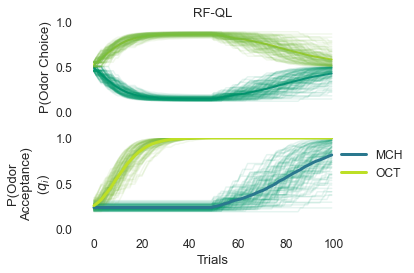

CQLearner_banditreject


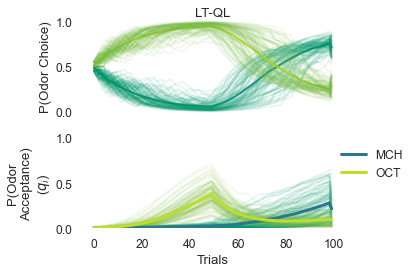

DFCQLearner_banditreject


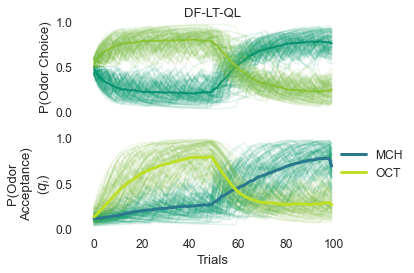

DFOSCQLearner_banditreject


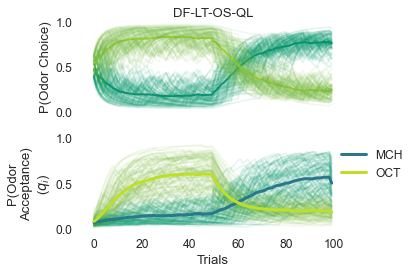

In [24]:
sns.set(style="ticks")
sns.set(font_scale=1.1)
sns.set_style("whitegrid")
from FlYMazeRL.utils import get_schedule_values
for model in [eval(m) for m in save_models]:
    model_name = model.__name__
    print(model_name)
    n_agents = 100
    
    schedule = generate_random_schedule_with_blocks(100,[0,1],[1,0],equal=False,block_sizes=[50,50])
    env = ymaze_static(100,schedule=schedule)
    params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
    weight = np.array([i['weight'] for i in policyparams])
    intercept = np.array([i['intercept'] for i in policyparams])
    values = get_schedule_values(env, model, n_agents, params, policyparams)
    values = sigmoid(np.array(values)*weight.reshape(-1,1,1) + intercept.reshape(-1,1,1))

    plt.figure(figsize=(6,4))

    ax = plt.subplot(2,1,1)
    odor_a_entropy = values[:,:,0]*(3-values[:,:,1])/(3*values[:,:,0]+3*values[:,:,1]-2*values[:,:,0]*values[:,:,1])
    odor_b_entropy = values[:,:,1]*(3-values[:,:,0])/(3*values[:,:,0]+3*values[:,:,1]-2*values[:,:,0]*values[:,:,1])
    plt.plot(np.nanmean(odor_a_entropy,axis=0),color=plt.cm.viridis(0.5),linewidth=2)
    for fly in range(n_agents):
        plt.plot(odor_a_entropy[fly,:],color=cmap(0.2),alpha=0.1)
    plt.plot(np.nanmean(odor_b_entropy,axis=0),color=plt.cm.viridis(0.9),linewidth=2)
    for fly in range(n_agents):
        plt.plot(odor_b_entropy[fly,:],color=cmap(0.9),alpha=0.1)
    plt.xticks([])
    plt.ylim([0,1])
    plt.ylabel('P(Odor Choice)')
    plt.box(False)
    plt.grid(False)
    plt.title(model_simple_abv_map[model_class_name_map[model_name]])

    plt.subplot(2,1,2)
    for fly in range(n_agents):
        plt.plot(values[fly,:,0],color=cmap(0.2),alpha=0.1)
        plt.plot(values[fly,:,1],color=cmap(0.95),alpha=0.1)
    plt.plot(values[:,:,0].mean(axis=0),color=plt.cm.viridis(0.4),linewidth=3,label='MCH')
    plt.plot(values[:,:,1].mean(axis=0),color=plt.cm.viridis(0.90),linewidth=3,label='OCT')
    plt.ylabel('P(Odor\nAcceptance)\n($q_i$)')
    plt.ylim([0,1])
    plt.legend(frameon=False,bbox_to_anchor=(0.95,1))
    plt.xlabel('Trials')
    plt.box(False)
    plt.grid(False)
    
    plt.tight_layout()
    
    plt.savefig('value_code_{}.svg'.format(model_simple_abv_map[model_class_name_map[model_name]]), transparent=True)
    plt.show()

RewardLearner_banditreject
CQLearner_banditreject
DFCQLearner_banditreject
DFOSCQLearner_banditreject


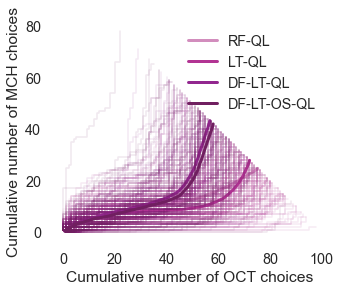

In [25]:
n_agents = 100
sns.set(style="ticks")
sns.set(font_scale=1.3)
plt.figure(figsize=(5,5))

for model in [eval(m) for m in save_models]:
    model_name = model.__name__
    color = save_model_color_map[model.__name__]
    print(model_name)

    schedule = generate_random_schedule_with_blocks(100,[1,0],[0,1],equal=False,block_sizes=[50,50])
    env = ymaze_static(100,schedule=schedule)
    params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
    histories = get_schedule_histories(env, model, n_agents, params, policyparams)
    histories = np.array(histories)

    for j in range(n_agents):
        plt.plot(np.cumsum(histories[j]==0),np.cumsum(histories[j]==1),'-',color=color,alpha=0.1)
    plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=color,label=model_simple_abv_map[model_class_name_map[model_name]])
    

plt.xlabel('Cumulative number of OCT choices')
plt.ylabel('Cumulative number of MCH choices')
plt.box(False)
plt.gca().set_aspect('equal')
plt.legend(frameon=False)
# plt.title('Best Model vs. Worst Model (50%:50%)')
plt.tight_layout()
plt.savefig('priming_case.svg', transparent=True)

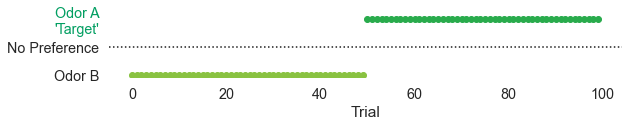

In [26]:
from FlYMazeRL.utils import draw_schedule
schedule = generate_random_schedule_with_blocks(100,[0,1],[1,0],equal=False,block_sizes=[50,50])
draw_schedule(schedule,figsize=(3,4),filename='schedule.svg',save=True)

## Model Separability

In [3]:
from FlYMazeRL.utils import get_schedule_values,generate_random_schedule,get_schedule_histories

X = []
Y = []
history_size = 12
n_schedules = 100
for i in tqdm(range(n_schedules)):
    schedule = generate_random_schedule(100,reward_fraction=0.5)
    for n,model in enumerate([eval(m) for m in save_models]):
        # model_name = model.__name__
        # print(model_name)
        n_agents = 100
        
        env = ymaze_static(100,schedule=schedule)
        params, policyparams = generate_params_from_fits(model, n_samples=n_agents, sample_from_population=True)
        action_history,reward_history = get_schedule_histories(env, model, n_agents, params, policyparams, False, True)
        action_history = np.array(action_history,dtype=float)
        reward_history = np.array(reward_history,dtype=float)

        # split reward history over actions
        reward_history_a = np.zeros_like(reward_history)
        reward_history_b = np.zeros_like(reward_history)
        reward_history_a[action_history==1] = reward_history[action_history==1]
        reward_history_b[action_history==0] = reward_history[action_history==0]

        # convolve action history and reward history with sliding window
        for j in range(n_agents):
            action_history[j,:] = np.convolve(action_history[j,:],np.ones(history_size)/history_size,mode='full')[history_size-1:]
            reward_history_a[j,:] = np.convolve(reward_history_a[j,:],np.ones(history_size)/history_size,mode='full')[history_size-1:]
            reward_history_b[j,:] = np.convolve(reward_history_b[j,:],np.ones(history_size)/history_size,mode='full')[history_size-1:]
            X.append(np.concatenate([action_history[j,:],reward_history_a[j,:],reward_history_b[j,:]]))
            Y.append((n,))

X = np.array(X)
Y = np.array(Y)

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
# randomize order
idx = np.random.permutation(X.shape[0])
X = X[idx]
Y = Y[idx]

# split into train and test
split_ratio = 0.8
X_train = X[:int(X.shape[0]*split_ratio)]
Y_train = Y[:int(Y.shape[0]*split_ratio)]
X_test = X[int(X.shape[0]*split_ratio):]
Y_test = Y[int(Y.shape[0]*split_ratio):]

# train model
from sklearn.neural_network import MLPClassifier

logreg = MLPClassifier(hidden_layer_sizes=(128,128,128),max_iter=1000,solver='adam',activation='tanh',verbose=True)
logreg.fit(X_train,Y_train)



C:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.37076411
Iteration 2, loss = 1.30211262
Iteration 3, loss = 1.27685308
Iteration 4, loss = 1.25333685
Iteration 5, loss = 1.23617530
Iteration 6, loss = 1.22817220
Iteration 7, loss = 1.21645837
Iteration 8, loss = 1.21086108
Iteration 9, loss = 1.20404750
Iteration 10, loss = 1.20015598
Iteration 11, loss = 1.19747539
Iteration 12, loss = 1.19149609
Iteration 13, loss = 1.18896039


C:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='tanh', hidden_layer_sizes=(128, 128, 128),
              max_iter=1000, verbose=True)

Accuracy: 0.251027984375


<AxesSubplot:>

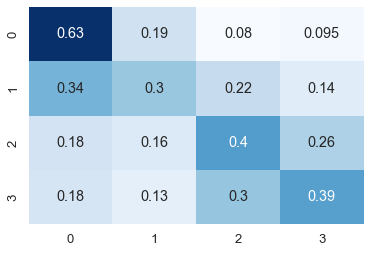

In [55]:
# test logistic regression
Y_pred = logreg.predict(X_test)

# print accuracy
print('Accuracy: {}'.format(np.mean(Y_pred==Y_test)))

# draw confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test,Y_pred,normalize='true')
sns.heatmap(cm,annot=True,cmap='Blues',cbar=False)

## Model Maximization

In [27]:
from FlYMazeRL.utils import get_schedule_values,generate_random_schedule,get_schedule_histories,draw_schedule


model = eval(save_models[0])

def generate_non_stationary_2AFC_schedule(max_trials,hazard_rate,reward_contrast,reward_gain):
    trace = np.zeros(max_trials)
    trace[0] = np.random.choice([0,1])
    for i in range(max_trials):
        if np.random.rand()<hazard_rate:
            trace[i] = 1 - trace[i-1]
        else:
            trace[i] = trace[i-1]
    choice_0 = np.ones(max_trials)*(reward_gain+reward_contrast/2)
    choice_1 = np.ones(max_trials)*(reward_gain-reward_contrast/2)
    a1 = np.where(trace==0,choice_0,choice_1)
    a2 = np.where(trace==1,choice_0,choice_1)
    return generate_random_schedule_with_blocks(max_trials, a1, a2)

def get_model_performance(model,n_schedules,n_agents_per_schedule,schedule_size,hazard_rate,reward_contrast,reward_gain,verbose=False):
    performance = []
    if verbose:
        r = tqdm(range(n_schedules))
    else:
        r = range(n_schedules)
    for i in r:
        schedule = generate_non_stationary_2AFC_schedule(schedule_size,hazard_rate,reward_contrast,reward_gain)
        env = ymaze_static(100,schedule=schedule)
        params, policyparams = generate_params_from_fits(model, n_samples=n_agents_per_schedule, sample_from_population=True)
        _,reward_history = get_schedule_histories(env, model, n_agents_per_schedule, params, policyparams, False, True)
        reward_history = np.array(reward_history,dtype=float)
        performance.append(np.mean(reward_history,axis=1))
    return np.concatenate(performance)

In [47]:
for model in tqdm(models):
    
    hazard_rates = np.logspace(-2,0,10)
    reward_contrasts = np.linspace(0,1,10)
    reward_gains = np.linspace(0,1,10)

    n_max = len(hazard_rates)*len(reward_contrasts)*len(reward_gains)

    # find all combinations of parameters

    n_schedules = 100
    n_agents_per_schedule = 1
    schedule_size = 500

    i = 0
    param_combinations = []
    for hazard_rate in hazard_rates:
        for reward_contrast in reward_contrasts:
            for reward_gain in reward_gains:
                print('{}/{}'.format(i,n_max),end='\r')
                i+=1
                # check if reward contrast and reward gain combination is valid
                if reward_gain+reward_contrast/2>1 or reward_gain-reward_contrast/2<0:
                    continue
                performance = get_model_performance(model,n_schedules,n_agents_per_schedule,schedule_size,hazard_rate,reward_contrast,reward_gain,verbose=False)
                param_combinations.append([hazard_rate,reward_contrast,reward_gain,np.mean(performance),np.std(performance),performance])

    df = pd.DataFrame(param_combinations,columns=['hazard_rate','reward_contrast','reward_gain','performance','performance_std','performance_history'])
    df['norm_performance'] = df['performance']/df['reward_gain']
    df['norm_performance_std'] = df['performance_std']/df['reward_gain']

    %matplotlib widget

    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import animation

    sns.set(font_scale=1.0)
    sns.set_style('whitegrid')

    fig = plt.figure(figsize=(10,5))

    ax1 = fig.add_subplot(121,projection='3d')
    ax2 = fig.add_subplot(122,projection='3d')

    def init():
        vmin = df['norm_performance'].min()
        vmax = df['norm_performance'].max()
        ax1.scatter3D(df['reward_contrast'],df['reward_gain'],np.log10(df['hazard_rate']),c=df['norm_performance'],s=50*df['performance'],vmin=vmin,vmax=vmax,cmap='Blues')
        vmin = df['norm_performance_std'].min()
        vmax = df['norm_performance_std'].max()
        ax2.scatter3D(df['reward_contrast'],df['reward_gain'],np.log10(df['hazard_rate']),c=df['norm_performance_std'],s=1e3*df['performance_std'],vmin=vmin,vmax=vmax,cmap='Reds')
        ax1.set_xlabel('Reward Contrast')
        ax1.set_ylabel('Reward Gain')
        ax1.set_zlabel('log10(Hazard Rate)')
        ax2.set_xlabel('Reward Contrast')
        ax2.set_ylabel('Reward Gain')
        ax2.set_zlabel('log10(Hazard Rate)')
        ax1.grid(False)
        ax2.grid(False)
        ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        plt.suptitle('Task Performance for {} Model'.format(model_simple_abv_map[model_class_name_map[model.__name__]]))
        return fig,

    def animate(i):
        ax1.view_init(elev=10., azim=i)
        ax2.view_init(elev=10., azim=i)
        return fig,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)

    anim.save(f'{model_simple_abv_map[model_class_name_map[model.__name__]]}.gif', fps=30)
    df.to_pickle(f'{model_simple_abv_map[model_class_name_map[model.__name__]]}_performance.pkl')


MovieWriter ffmpeg unavailable; using Pillow instead.


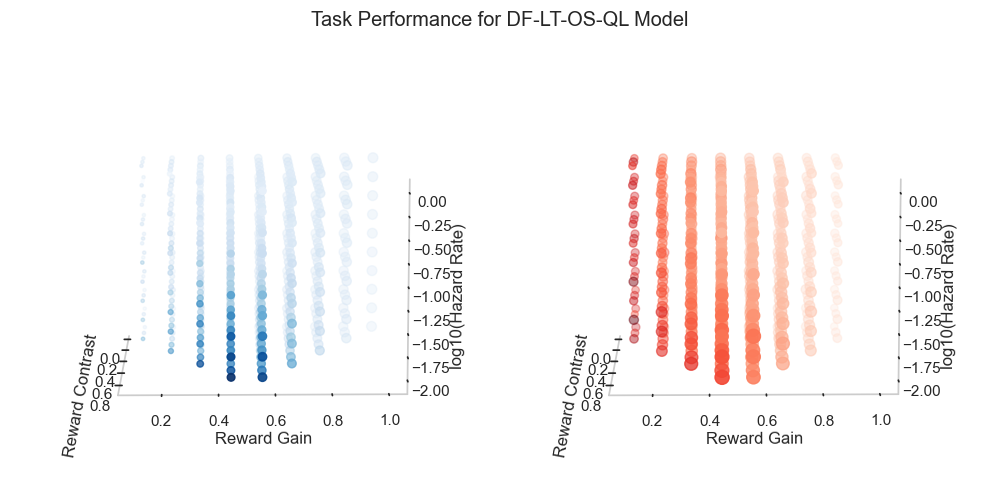

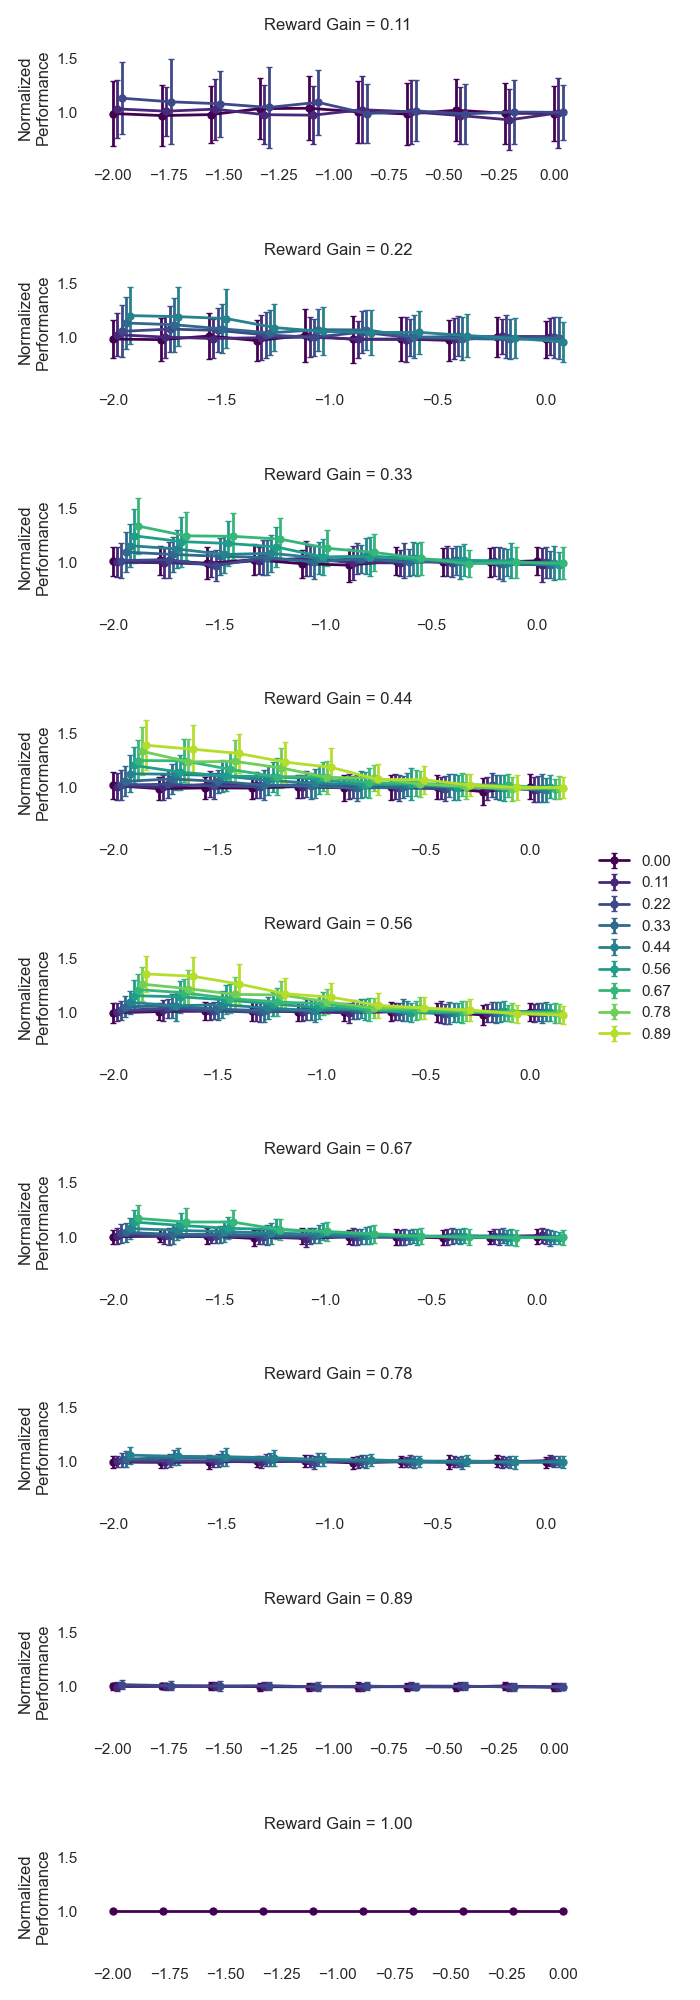

In [127]:
summary_df = df.groupby(['hazard_rate','reward_contrast','reward_gain']).mean()
summary_df.reset_index(inplace=True)
# plot norm_performance as a function of hazard rate using seaborn
sns.set(font_scale=1.0)
sns.set_style('whitegrid')
fig = plt.figure(figsize=(7,20))
for m,i in enumerate(summary_df.reward_gain.unique()[1:]):
    ax = fig.add_subplot(9,1,m+1)
    temp = summary_df[summary_df.reward_gain==i]
    for n,j in enumerate(temp.reward_contrast.unique()):
        temp2 = temp[temp.reward_contrast==j]
        ax.errorbar(np.log10(temp2.hazard_rate)+n/50,temp2.norm_performance,temp2.norm_performance_std,label='{0:.2f}'.format(j),linewidth=2,color=plt.cm.viridis(j),marker='o',markersize=5,capsize=2)
    ax.set_ylabel('Normalized\nPerformance')
    ax.grid(False)
    if m == 4:
        plt.legend(loc='lower center',bbox_to_anchor=(1.1,0.0),frameon=False)
    if m == 9:
        ax.set_xlabel('Hazard Rate')
    ax.set_ylim(0.6,summary_df.norm_performance.max()+0.3)
    plt.title('Reward Gain = {0:.2f}'.format(i))
    plt.box(False)
plt.tight_layout()
plt.show()
